##### The University of Melbourne, School of Computing and Information Systems

**COMP30027 Machine Learning, 2022 Semester 1**

---

# **Assignment 2:** Sentiment Classification of Tweets

---

In [103]:
''' To use this Notebook, you'll need to install the following modules
- pandas
- numpy
- scipy
- sklearn
- matplotlib
- wordcloud
- nltk
'''
# general use
import pandas as pd
from collections import Counter, defaultdict
import numpy as np
from scipy.sparse import csr_matrix, hstack, vstack
from scipy.stats import t
from pprint import pprint
import sklearn as skl
import warnings
from time import time
# plotting
import matplotlib.pyplot as plt
from wordcloud import WordCloud
# feature extraction
import re
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords, cmudict
NLTK_STOPWORDS = list(stopwords.words())
NLTK_CMU = cmudict.dict()
from nltk.stem import PorterStemmer, WordNetLemmatizer
# classifiers
from sklearn.base import clone
from sklearn.model_selection import ParameterGrid
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import BaggingClassifier
# evaluation
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# set the plot font sizes
# ref: https://stackoverflow.com/questions/3899980/how-to-change-the-font-size-on-a-matplotlib-plot
SMALL_SIZE = 26
MEDIUM_SIZE = 30
BIGGER_SIZE = 34
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

[nltk_data] Downloading package stopwords to C:\Users\Xavier
[nltk_data]     Travers\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 1. Raw Data Analysis

A shallow analysis of the dataset.

### Importing the data

In [2]:
train_df = pd.read_csv("../data/Train.csv", sep=',')
test_df = pd.read_csv("../data/Test.csv", sep=',')

### Basic Information
Specifically the types of the data and the lengths of each set.

In [3]:
# get information about types in the training set
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21802 entries, 0 to 21801
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  21802 non-null  int64 
 1   id          21802 non-null  int64 
 2   text        21802 non-null  object
 3   sentiment   21802 non-null  object
dtypes: int64(2), object(2)
memory usage: 681.4+ KB


In [4]:
# get information about types in the testing set
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6099 entries, 0 to 6098
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      6099 non-null   int64 
 1   text    6099 non-null   object
dtypes: int64(1), object(1)
memory usage: 95.4+ KB


### Inspecting Instances 
To verify what they look like when `pandas` imports them.

In [5]:
# inspect the head of the training information
train_df.head()

,Unnamed: 0,id,text,sentiment
0,2,805582613687713000,doctors hit campaign trail as race to medical...,neutral
1,3,637480203497832000,is anybody going to the radio station tomorro...,positive
2,4,641096279930507000,i just found out naruto didn't become the 5th...,neutral
3,5,625730917647126000,"""prince george reservist who died saturday ju...",neutral
4,6,633292370906230000,season in the sun versi nirvana rancak gak..s...,positive


In [6]:
# inspect the head of the testing information
test_df.head()

,id,text
0,802217876644052000,@loogunda @poroshenko putin abducted ukrainia...
1,802425296955682000,if putin wanted to intervene all he would hav...
2,805664502515662000,@hillbuzz @gaypatriot elsewhere in progland.....
3,639928670103015000,any females copping the gucci foamposites tom...
4,673824182287904000,"""in other news, had a great saturday on the t..."


In [7]:
# show a random sample from the training information
train_df.sample(5)

,Unnamed: 0,id,text,sentiment
7995,10205,635599578092302000,first day of school tomorrow! oh yeah it's a...,neutral
14126,18121,805631847568838000,@actparty english has opposed abortion volunt...,neutral
17898,22787,802200976849587000,@caseycdutch trump always appeared uncomfort...,neutral
15646,20086,637976217501741000,@stevecherelle yes!! i do love a bit of zac b...,positive
6626,8420,638081082689110000,this girl who literally bullied me since 7th ...,negative


In [8]:
# show a random sample from the testing information
test_df.sample(5)

,id,text
4475,805667069907836000,@stopkillingcycl @coshgirl over here in malta...
3431,678770012874653000,follow the top amy schumer stories for dec 21...
922,622830531470827000,@rq1927 @seymouranthony @harryhill99 @therealk...
2254,662139635909324000,"""i may be shit at guitar but at least i can w..."
4050,641591794854162000,@mikeandmike floyd mayweather is going to buy ...


### Distribution of Sentiments

There may be a majority sentiment in the `Train.csv`.

Counter({'neutral': 12659, 'positive': 5428, 'negative': 3715})


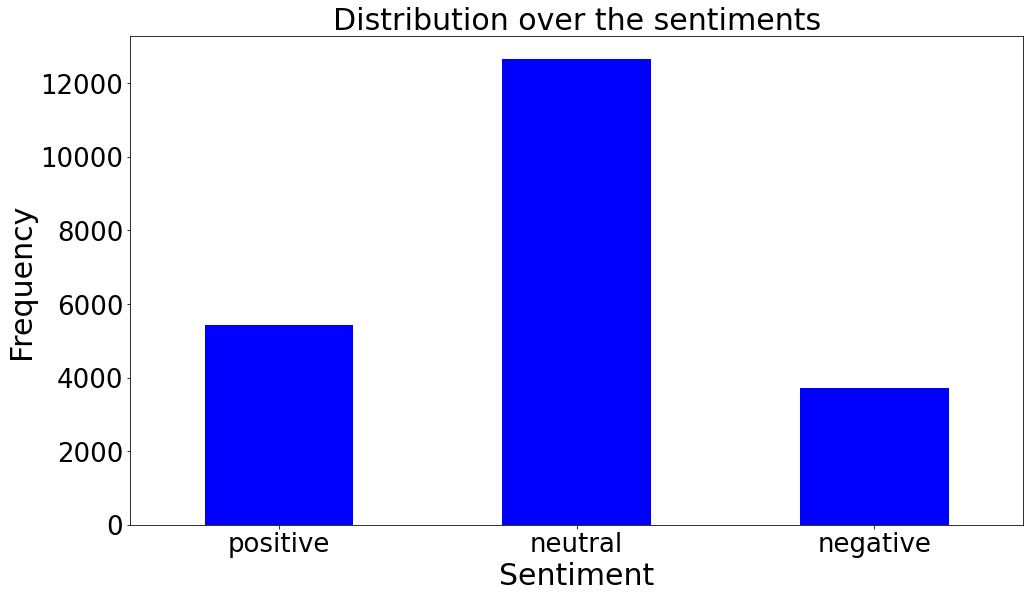

In [9]:
# Sentiment options and counts
print(Counter(train_df[['sentiment']].values[:, 0]))

# Distribution of the data between the sentiments
train_df.groupby('sentiment').count().sort_values('sentiment', ascending=False).plot.bar(
    legend=False, figsize=(16, 9), color='blue', rot=0)
plt.xlabel('Sentiment')
plt.ylabel('Frequency')
plt.title('Distribution over the sentiments')
plt.savefig('../report/img/sentiment-distribution', bbox_inches='tight')

## 2. Data Preprocessing

Functionality for cleaning the text data

### Cleaning Functionality
A simple cleaning function for the data with modifiable features.

In [10]:
## pre-cache the regex
# common tweet feature regex
RE_LINKS = re.compile(r'https?://t.co/\w*')
RE_HASHTAGS = re.compile(r'(?<=\W)#\w*[a-z]\w*')
RE_MENTIONS = re.compile(r'(?<=\W)@\w+')
# other re
RE_REPEATED_CONSECUTIVES = re.compile(r'(.)\1+')
RE_NUMBERS = re.compile(r'\d+')
RE_NON_ALPHANUMERIC = re.compile(r'[^a-z]+')
RE_PUNCTUATION = re.compile(r'[\.?!,:;\-()\[\]{}"\'/]')

# list of different terms to clean
DEFAULT_CLEAN_DICT = {
    'links': True,
    'hashtags': True,
    'mentions': True,
    'numbers': True,
    'non-alphanumeric': True,
    'repeated-consecutive': True,
    'stopwords': None, # removing stopwords
}

# a function to selectively clean different terms within tweets
def clean_tweet(tweet: str, remove: dict = DEFAULT_CLEAN_DICT) -> str:
    new_tweet = tweet
    re_stopwords = ''
    if remove['stopwords'] is not None: 
        re_stopwords = re.compile(r'\b(' + r'|'.join(remove['stopwords']) + r')\b\s*')
    if remove['links']: new_tweet = RE_LINKS.sub(' ', new_tweet)
    if remove['hashtags']: new_tweet = RE_HASHTAGS.sub(' ', new_tweet)
    if remove['mentions']: new_tweet = RE_MENTIONS.sub(' ', new_tweet)
    if remove['stopwords'] is not None:
        new_tweet = re_stopwords.sub(' ', new_tweet)
    if remove['repeated-consecutive']: new_tweet = RE_REPEATED_CONSECUTIVES.sub(r'\1\1', new_tweet)
    if remove['numbers']: new_tweet = RE_NUMBERS.sub(' ', new_tweet)
    if remove['stopwords'] is not None:
        new_tweet = re_stopwords.sub(' ', new_tweet)
    if remove['non-alphanumeric']: 
        new_tweet = RE_NON_ALPHANUMERIC.sub(' ', new_tweet)
    if remove['stopwords'] is not None:
        new_tweet = re_stopwords.sub(' ', new_tweet)

    # remove unnecessary space characters
    new_tweet = re.sub(r' +', ' ', new_tweet)
    new_tweet = re.sub(r'^ | $', '', new_tweet) # bookend spaces
    return new_tweet

# apply the default cleaning function to the training and test sets
train_df['text-clean-no-stopwords'] = train_df['text'].apply(clean_tweet)
test_df['text-clean-no-stopwords'] = test_df['text'].apply(clean_tweet)

# inspect a sample of the training information and compare the clean and raw tweets
train_df.sample(5)

,Unnamed: 0,id,text,sentiment,text-clean-no-stopwords
9002,11513,802405205258010000,that could be the solution to the obamacare s...,neutral,that could be the solution to the obamacare sh...
20144,25713,622561601032470000,tomorrow is national ice cream day! sunday jul...,positive,tomorrow is national ice cream day sunday july...
11261,14408,625899808650317000,i attended tulo's final game in a rockies uni...,positive,i attended tulo s final game in a rockies unif...
5645,7180,801864167758172000,it is not the 1800's anymore john. remember 9...,negative,it is not the s anymore john remember there ar...
3836,4894,662420349380902000,celebrate the life and music of george harris...,positive,celebrate the life and music of george harriso...


### Identifying Stopwords
Words with little value to be removed

In [11]:
# start the wordcloud object here
wc = WordCloud(max_words=750, width=1920, height=1080)
GENERATE_WORD_CLOUDS = False

# a function to display and save a named word cloud
def show_save_word_cloud(text, filename):
    cloud = wc.generate(text)
    plt.figure(figsize= (16, 9), frameon=False)
    plt.axis('off')
    print(f'Word cloud for {filename}')
    plt.imshow(cloud)
    plt.savefig(f'../report/img/wc/{filename}', bbox_inches='tight')

# show and save the wc for train, test, all
if GENERATE_WORD_CLOUDS: # this takes a while to run, so change this to run it again
    # show_save_word_cloud(" ".join(train_df['text-clean-default']), 'train-clean-default')
    # show_save_word_cloud(" ".join(test_df['text-clean-default']), 'test-clean-default')
    show_save_word_cloud(" ".join(train_df['text-clean-no-stopwords']) + " " + " ".join(test_df['text-clean-no-stopwords']), 
        'text-clean-no-stopwords')

    # generate the wc for `positive`, `neutral` and `negative` instances only
    for sentiment in set(train_df['sentiment']):
        show_save_word_cloud(" ".join(train_df['text-clean-no-stopwords']),
        f'{sentiment}-clean-no-stopwords')

In [12]:
# NLTK's stopword list is most applicable (+ add stuff from re-analysis)
FINAL_STOPWORDS = ['amp', 'th', 'st'] + NLTK_STOPWORDS
TEXT_VERSION_RAW = 'text'

# apply the cleaning with the different stopword lists
cleanConfig = DEFAULT_CLEAN_DICT.copy()
cleanConfig['stopwords'] = NLTK_STOPWORDS
TEXT_VERSION_NLTK = 'text-clean-nltk'
train_df[TEXT_VERSION_NLTK] = train_df[TEXT_VERSION_RAW].apply(lambda t: clean_tweet(t, cleanConfig))
test_df[TEXT_VERSION_NLTK] = test_df[TEXT_VERSION_RAW].apply(lambda t: clean_tweet(t, cleanConfig))
cleanConfig['stopwords'] = FINAL_STOPWORDS
TEXT_VERSION_FINAL = 'text-clean'
train_df[TEXT_VERSION_FINAL] = train_df[TEXT_VERSION_RAW].apply(lambda t: clean_tweet(t, cleanConfig))
test_df[TEXT_VERSION_FINAL] = test_df[TEXT_VERSION_RAW].apply(lambda t: clean_tweet(t, cleanConfig))

FINAL_CLEAN_CONFIG = cleanConfig

# generate the wc for the nltk cleaned all, `positive`, `neutral` and `negative` instances
if GENERATE_WORD_CLOUDS: # this takes a while to run, so change this to run it again
    show_save_word_cloud(" ".join(train_df[TEXT_VERSION_NLTK]) + " " + " ".join(test_df[TEXT_VERSION_NLTK]), 
        'all-clean-nltk')
    for sentiment in set(train_df['sentiment']):
        show_save_word_cloud(" ".join(train_df[TEXT_VERSION_NLTK]),
        f'{sentiment}-clean-nltk')

    # generate the wc for the nltk cleaned all, `positive`, `neutral` and `negative` instances
    show_save_word_cloud(" ".join(train_df[TEXT_VERSION_FINAL]) + " " + " ".join(test_df[TEXT_VERSION_FINAL]), 
        'all-clean-final')
    for sentiment in set(train_df['sentiment']):
        show_save_word_cloud(" ".join(train_df[TEXT_VERSION_FINAL]),
        f'{sentiment}-clean-final')

# compare the differences
train_df.sample(5)

,Unnamed: 0,id,text,sentiment,text-clean-no-stopwords,text-clean-nltk,text-clean
13726,17611,672071920377077000,"""millions aren't terrorist sympathisers. some...",negative,millions aren t terrorist sympathisers some wh...,millions terrorist sympathisers friends hamas ...,millions terrorist sympathisers friends hamas ...
19577,24949,639088215098568000,eye am going to the ed sheeran concerns and ha...,positive,eye am going to the ed sheeran concerns and ha...,eye going sheeran concerns hanging mom,eye going sheeran concerns hanging mom
14916,19159,665584994048430000,fyi this pic is actually from the charlie heb...,negative,fyi this pic is actually from the charlie hebd...,fyi actually charlie hebdo tragedy january fre...,fyi actually charlie hebdo tragedy january fre...
2404,3068,676754399302152000,happy tuesday. our countdown to christmas con...,positive,happy tuesday our countdown to christmas conti...,happy tuesday countdown christmas continues to...,happy tuesday countdown christmas continues to...
1372,1765,802361238655266000,obama expanded the papahanaumokuakea underwat...,positive,obama expanded the papahanaumokuakea underwate...,obama expanded papahanaumokuakea underwater re...,obama expanded papahanaumokuakea underwater re...


## 3. Vectorizers
Three transformers are going to be used `TfidfVectorizer`, `CountVectorizer` and `DictVectorizer`.
The following is code to compare the different features produced on a bar graph (showing those most influential).

In [13]:
# define the colours for the different sentiment sets
SENTIMENT_COLOURS = {
    'all': 'orange',
    'positive': 'green',
    'neutral': 'blue',
    'negative': 'red'
}

# create a bar graph (and save it)
def show_save_bar_graph(plot, X:csr_matrix, y: list[str], features: list[str], 
        feature_type: str, sentiment: str, sort_type: str='relative', 
        max_features: int|None=10, labels=False, save=False):

    # ensure the max features are not higher than the length
    if max_features > len(features) or max_features == None: 
        max_features = len(features)
    # fill the value list for the bars
    values = np.zeros((len(features)))
    sums = np.zeros((len(features)))
    for idx, f in enumerate(features):
        all_entries = X[:, idx]
        s_entries = all_entries[y == sentiment]
        sums[idx] = np.sum(all_entries)
        if sentiment == 'all': 
            values[idx] = np.sum(all_entries) / len(y)
        elif sort_type == 'relative':
            values[idx] = np.sum(s_entries) / np.sum(all_entries)
        else:
            values[idx] = np.sum(s_entries) / len(y[y == sentiment])
    values_sums_names = sorted(zip(values, sums, features), reverse=True)[:max_features]
    values = [vn[0] for vn in values_sums_names]
    features = [vn[2] for vn in values_sums_names]
    plot.bar(range(max_features), values, color=SENTIMENT_COLOURS[sentiment])
    if labels:
        plot.xlabel(f'Top {max_features} Features',) 
        plot.ylabel(f'{sort_type} Value',) 
    plot.set_xticks(range(max_features))
    plot.set_xticklabels(features, rotation=45, ha='right')
    plot.set_title(f'{sentiment.upper()} {feature_type} Bar Graph')
    if save:
        plt.savefig(f'../report/img/bar/{sentiment}', bbox_inches='tight')


# create a method to generate 4 bar graphs for top features in a vector based on their relative sums
def compare_bars(X, y, features, feature_type: str, sort_type: str='relative', max_features: int|None=10):

    if max_features > len(features): max_features = len(features)
    f, axes = plt.subplots(1, 4)
    f.set_size_inches([32, 12])

    # set the labels
    f.supxlabel(f'Top {max_features} Features', va='baseline')
    f.supylabel(f'{sort_type.upper()} Value')
    f.suptitle(f'Comparing {feature_type} across sentiments')
    f.subplots_adjust(bottom=0.25, wspace=0.3)

    show_save_bar_graph(axes[0], X, y, features, '-', 'all', sort_type, max_features)

    for idx, sentiment in enumerate(['positive', 'neutral', 'negative']):
        show_save_bar_graph(axes[idx+1], X, y, features, '-', sentiment, sort_type, max_features)

    plt.savefig(f'../report/img/bar/compare-{feature_type}', bbox_inches='tight')


## 4. Tokenization

Implementing different forms of token/vector generation.

In [14]:
# define the X dictionaries and y for the sentiments
X_train_features = dict()
X_test_features = dict()
X_vectorizers = dict()
X_text_versions = defaultdict(lambda: TEXT_VERSION_RAW)
y = train_df['sentiment']

# for the sake of comparison/testing, set the # of max features to smth low
MAX_FEATURES = 10000 # Modify this for M_f
USE_BINARY = False
USE_TFIDF = False
GENERATE_GRAPHS = False

### Words

In [15]:
# test the regular word split tokenization on the count/bag-of-words
FEATURE_WORDS_COUNT = 'Word Occurrence Counts'
X_text_versions[FEATURE_WORDS_COUNT] = TEXT_VERSION_FINAL
X_vectorizers[FEATURE_WORDS_COUNT] = CountVectorizer(max_features=MAX_FEATURES, binary=USE_BINARY)
if GENERATE_GRAPHS:
    X_train_features[FEATURE_WORDS_COUNT] = X_vectorizers[FEATURE_WORDS_COUNT].fit_transform(train_df[TEXT_VERSION_FINAL])
    X_test_features[FEATURE_WORDS_COUNT] = X_vectorizers[FEATURE_WORDS_COUNT].transform(test_df[TEXT_VERSION_FINAL])
    compare_bars(X_train_features[FEATURE_WORDS_COUNT], y, X_vectorizers[FEATURE_WORDS_COUNT].get_feature_names_out(), FEATURE_WORDS_COUNT)

# test the regular word split tokenization on the tf-idf
FEATURE_WORDS_TFIDF = 'TF-IDF of Words'
X_text_versions[FEATURE_WORDS_TFIDF] = TEXT_VERSION_FINAL
X_vectorizers[FEATURE_WORDS_TFIDF] = TfidfVectorizer(max_features=MAX_FEATURES)
if GENERATE_GRAPHS:
    X_train_features[FEATURE_WORDS_TFIDF] = X_vectorizers[FEATURE_WORDS_TFIDF].fit_transform(train_df[TEXT_VERSION_FINAL])
    X_test_features[FEATURE_WORDS_TFIDF] = X_vectorizers[FEATURE_WORDS_TFIDF].transform(test_df[TEXT_VERSION_FINAL])
    compare_bars(X_train_features[FEATURE_WORDS_TFIDF], y, X_vectorizers[FEATURE_WORDS_TFIDF].get_feature_names_out(), FEATURE_WORDS_TFIDF)

### Lemmas

In [16]:
wnl = WordNetLemmatizer()
def tokenizer_lemmas(tweet):
    return [wnl.lemmatize(w) for w in tweet.split(' ')]

# test the regular lemma split tokenization on the count/bag-of-words
FEATURE_LEMMAS_COUNT = 'Lemma Occurrence Counts'
X_text_versions[FEATURE_LEMMAS_COUNT] = TEXT_VERSION_FINAL
X_vectorizers[FEATURE_LEMMAS_COUNT] = CountVectorizer(max_features=MAX_FEATURES, binary=USE_BINARY, tokenizer=tokenizer_lemmas)
if GENERATE_GRAPHS:
    X_train_features[FEATURE_LEMMAS_COUNT] = X_vectorizers[FEATURE_LEMMAS_COUNT].fit_transform(train_df[TEXT_VERSION_FINAL])
    X_test_features[FEATURE_LEMMAS_COUNT] = X_vectorizers[FEATURE_LEMMAS_COUNT].transform(test_df[TEXT_VERSION_FINAL])
    compare_bars(X_train_features[FEATURE_LEMMAS_COUNT], y, X_vectorizers[FEATURE_LEMMAS_COUNT].get_feature_names_out(), FEATURE_LEMMAS_COUNT)

# test the regular lemma split tokenization on the tf-idf
FEATURE_LEMMAS_TFIDF = 'TF-IDF of Lemmas'
X_text_versions[FEATURE_LEMMAS_TFIDF] = TEXT_VERSION_FINAL
X_vectorizers[FEATURE_LEMMAS_TFIDF] = TfidfVectorizer(max_features=MAX_FEATURES, tokenizer=tokenizer_lemmas)
if GENERATE_GRAPHS:
    X_train_features[FEATURE_LEMMAS_TFIDF] = X_vectorizers[FEATURE_LEMMAS_TFIDF].fit_transform(train_df[TEXT_VERSION_FINAL])
    X_test_features[FEATURE_LEMMAS_TFIDF] = X_vectorizers[FEATURE_LEMMAS_TFIDF].transform(test_df[TEXT_VERSION_FINAL])
    compare_bars(X_train_features[FEATURE_LEMMAS_TFIDF], y, X_vectorizers[FEATURE_LEMMAS_TFIDF].get_feature_names_out(), FEATURE_LEMMAS_TFIDF)

### Part-of-speech Tags

In [17]:
# Define the tags list
def tokenizer_pos(tweet): return [t[1] for t in nltk.pos_tag(tweet.split(' '))]

# test the stemming split tokenization on the count/bag-of-words
FEATURE_POS_TAGS_COUNT = 'Part-of-speech Tag Occurrence Counts'
X_text_versions[FEATURE_POS_TAGS_COUNT] = TEXT_VERSION_FINAL
X_vectorizers[FEATURE_POS_TAGS_COUNT] = CountVectorizer(max_features=MAX_FEATURES, binary=USE_BINARY, tokenizer=tokenizer_pos)
if GENERATE_GRAPHS:
    X_train_features[FEATURE_POS_TAGS_COUNT] = X_vectorizers[FEATURE_POS_TAGS_COUNT].fit_transform(train_df[TEXT_VERSION_FINAL])
    X_test_features[FEATURE_POS_TAGS_COUNT] = X_vectorizers[FEATURE_POS_TAGS_COUNT].transform(test_df[TEXT_VERSION_FINAL])
    compare_bars(X_train_features[FEATURE_POS_TAGS_COUNT], y, X_vectorizers[FEATURE_POS_TAGS_COUNT].get_feature_names_out(), FEATURE_POS_TAGS_COUNT)

# test the stemming split tokenization on the tf-idf
FEATURE_POS_TAGS_TFIDF = 'TF-IDF of Part-of-speech Tags'
X_text_versions[FEATURE_POS_TAGS_TFIDF] = TEXT_VERSION_FINAL
X_vectorizers[FEATURE_POS_TAGS_TFIDF] = TfidfVectorizer(max_features=MAX_FEATURES, tokenizer=tokenizer_pos)
if GENERATE_GRAPHS:
    X_train_features[FEATURE_POS_TAGS_TFIDF] = X_vectorizers[FEATURE_POS_TAGS_TFIDF].fit_transform(train_df[TEXT_VERSION_FINAL])
    X_test_features[FEATURE_POS_TAGS_TFIDF] = X_vectorizers[FEATURE_POS_TAGS_TFIDF].transform(test_df[TEXT_VERSION_FINAL])
    compare_bars(X_train_features[FEATURE_POS_TAGS_TFIDF], y, X_vectorizers[FEATURE_POS_TAGS_TFIDF].get_feature_names_out(), FEATURE_POS_TAGS_TFIDF)

### Stems

In [18]:
# Porter Stemmer
ps = PorterStemmer()
def tokenizer_stem(tweet): return [ps.stem(w) for w in tweet.split(' ')]

# test the stemming split tokenization on the count/bag-of-words
FEATURE_STEMS_COUNT = 'English Stemmed Word Occurrence Counts'
X_text_versions[FEATURE_STEMS_COUNT] = TEXT_VERSION_FINAL
X_vectorizers[FEATURE_STEMS_COUNT] = CountVectorizer(max_features=MAX_FEATURES, binary=USE_BINARY, tokenizer=tokenizer_stem)
if GENERATE_GRAPHS:
    X_train_features[FEATURE_STEMS_COUNT] = X_vectorizers[FEATURE_STEMS_COUNT].fit_transform(train_df[TEXT_VERSION_FINAL])
    X_test_features[FEATURE_STEMS_COUNT] = X_vectorizers[FEATURE_STEMS_COUNT].transform(test_df[TEXT_VERSION_FINAL])
    compare_bars(X_train_features[FEATURE_STEMS_COUNT], y, X_vectorizers[FEATURE_STEMS_COUNT].get_feature_names_out(), FEATURE_STEMS_COUNT)

# test the stemming split tokenization on the tf-idf
FEATURE_STEMS_TFIDF = 'TF-IDF of English Stemmed Words'
X_text_versions[FEATURE_STEMS_TFIDF] = TEXT_VERSION_FINAL
X_vectorizers[FEATURE_STEMS_TFIDF] = TfidfVectorizer(max_features=MAX_FEATURES, tokenizer=tokenizer_stem)
if GENERATE_GRAPHS:
    X_train_features[FEATURE_STEMS_TFIDF] = X_vectorizers[FEATURE_STEMS_TFIDF].fit_transform(train_df[TEXT_VERSION_FINAL])
    X_test_features[FEATURE_STEMS_TFIDF] = X_vectorizers[FEATURE_STEMS_TFIDF].transform(test_df[TEXT_VERSION_FINAL])
    compare_bars(X_train_features[FEATURE_STEMS_TFIDF], y, X_vectorizers[FEATURE_STEMS_TFIDF].get_feature_names_out(), FEATURE_STEMS_TFIDF)

### 2-Grams

In [19]:
# Test on occurrences
FEATURE_WORD_2GRAMS_COUNT = 'Word 2-Gram Occurrence Counts'
X_text_versions[FEATURE_WORD_2GRAMS_COUNT] = TEXT_VERSION_FINAL
X_vectorizers[FEATURE_WORD_2GRAMS_COUNT] = CountVectorizer(max_features=MAX_FEATURES, binary=USE_BINARY, ngram_range=(2, 2))
if GENERATE_GRAPHS:
    X_train_features[FEATURE_WORD_2GRAMS_COUNT] = X_vectorizers[FEATURE_WORD_2GRAMS_COUNT].fit_transform(train_df[TEXT_VERSION_FINAL])
    X_test_features[FEATURE_WORD_2GRAMS_COUNT] = X_vectorizers[FEATURE_WORD_2GRAMS_COUNT].transform(test_df[TEXT_VERSION_FINAL])
    compare_bars(X_train_features[FEATURE_WORD_2GRAMS_COUNT], y, X_vectorizers[FEATURE_WORD_2GRAMS_COUNT].get_feature_names_out(), FEATURE_WORD_2GRAMS_COUNT)

# Test on occurrences
FEATURE_LEMMA_2GRAMS_COUNT = 'Lemma 2-Gram Occurrence Counts'
X_text_versions[FEATURE_LEMMA_2GRAMS_COUNT] = TEXT_VERSION_FINAL
X_vectorizers[FEATURE_LEMMA_2GRAMS_COUNT] = CountVectorizer(max_features=MAX_FEATURES, binary=USE_BINARY, ngram_range=(2, 2), tokenizer=tokenizer_lemmas)
if GENERATE_GRAPHS:
    X_train_features[FEATURE_LEMMA_2GRAMS_COUNT] = X_vectorizers[FEATURE_LEMMA_2GRAMS_COUNT].fit_transform(train_df[TEXT_VERSION_FINAL])
    X_test_features[FEATURE_LEMMA_2GRAMS_COUNT] = X_vectorizers[FEATURE_LEMMA_2GRAMS_COUNT].transform(test_df[TEXT_VERSION_FINAL])
    compare_bars(X_train_features[FEATURE_LEMMA_2GRAMS_COUNT], y, X_vectorizers[FEATURE_LEMMA_2GRAMS_COUNT].get_feature_names_out(), FEATURE_LEMMA_2GRAMS_COUNT)

# Test on tfidf
FEATURE_WORD_2GRAMS_TFIDF = 'TF-IDF of Word 2-Grams'
X_text_versions[FEATURE_WORD_2GRAMS_TFIDF] = TEXT_VERSION_FINAL
X_vectorizers[FEATURE_WORD_2GRAMS_TFIDF] = TfidfVectorizer(max_features=MAX_FEATURES, ngram_range=(2, 2))
if GENERATE_GRAPHS:
    X_train_features[FEATURE_WORD_2GRAMS_TFIDF] = X_vectorizers[FEATURE_WORD_2GRAMS_TFIDF].fit_transform(train_df[TEXT_VERSION_FINAL])
    X_test_features[FEATURE_WORD_2GRAMS_TFIDF] = X_vectorizers[FEATURE_WORD_2GRAMS_TFIDF].transform(test_df[TEXT_VERSION_FINAL])
    compare_bars(X_train_features[FEATURE_WORD_2GRAMS_TFIDF], y, X_vectorizers[FEATURE_WORD_2GRAMS_TFIDF].get_feature_names_out(), FEATURE_WORD_2GRAMS_TFIDF)

# tokenizer by stemming instead
# Test on occurrences
FEATURE_STEM_2GRAMS_COUNT = 'English Stemmed 2-Gram Occurrence Counts'
X_text_versions[FEATURE_STEM_2GRAMS_COUNT] = TEXT_VERSION_FINAL
X_vectorizers[FEATURE_STEM_2GRAMS_COUNT] = CountVectorizer(max_features=MAX_FEATURES, binary=USE_BINARY, ngram_range=(2, 2), tokenizer=tokenizer_stem)
if GENERATE_GRAPHS:
    X_train_features[FEATURE_STEM_2GRAMS_COUNT] = X_vectorizers[FEATURE_STEM_2GRAMS_COUNT].fit_transform(train_df[TEXT_VERSION_FINAL])
    X_test_features[FEATURE_STEM_2GRAMS_COUNT] = X_vectorizers[FEATURE_STEM_2GRAMS_COUNT].transform(test_df[TEXT_VERSION_FINAL])
    compare_bars(X_train_features[FEATURE_STEM_2GRAMS_COUNT], y, X_vectorizers[FEATURE_STEM_2GRAMS_COUNT].get_feature_names_out(), FEATURE_STEM_2GRAMS_COUNT)

# Test on tfidf
FEATURE_STEM_2GRAMS_TFIDF = 'TF-IDF of English Stemmed 2-Grams'
X_text_versions[FEATURE_STEM_2GRAMS_TFIDF] = TEXT_VERSION_FINAL
X_vectorizers[FEATURE_STEM_2GRAMS_TFIDF] = TfidfVectorizer(max_features=MAX_FEATURES, ngram_range=(2, 2), tokenizer=tokenizer_stem)
if GENERATE_GRAPHS:
    X_train_features[FEATURE_STEM_2GRAMS_TFIDF] = X_vectorizers[FEATURE_STEM_2GRAMS_TFIDF].fit_transform(train_df[TEXT_VERSION_FINAL])
    X_test_features[FEATURE_STEM_2GRAMS_TFIDF] = X_vectorizers[FEATURE_STEM_2GRAMS_TFIDF].transform(test_df[TEXT_VERSION_FINAL])
    compare_bars(X_train_features[FEATURE_STEM_2GRAMS_TFIDF], y, X_vectorizers[FEATURE_STEM_2GRAMS_TFIDF].get_feature_names_out(), FEATURE_STEM_2GRAMS_TFIDF)

### Characters

In [20]:
def tokenizer_char(tweet, char_type = 'alphabetic'): 
    if char_type == 'alphabetic':
        t = re.sub(r'[^a-z]+', '', tweet)
        return list(t)
    elif char_type == 'non-word':
        t = re.sub(r'[\w\s]+', '', tweet)
        return list(t)
    elif char_type == 'punctuation':
        return RE_PUNCTUATION.findall(tweet)
    else:
        return list(tweet)

# test the regular word split tokenization on the count/bag-of-words
FEATURE_ALPHABETICS_COUNT = 'Alphabetic Occurrence Counts'
X_vectorizers[FEATURE_ALPHABETICS_COUNT] = CountVectorizer(max_features=MAX_FEATURES, binary=USE_BINARY, tokenizer=tokenizer_char)
if GENERATE_GRAPHS:
    X_train_features[FEATURE_ALPHABETICS_COUNT] = X_vectorizers[FEATURE_ALPHABETICS_COUNT].fit_transform(train_df[TEXT_VERSION_RAW])
    X_test_features[FEATURE_ALPHABETICS_COUNT] = X_vectorizers[FEATURE_ALPHABETICS_COUNT].transform(test_df[TEXT_VERSION_RAW])
    compare_bars(X_train_features[FEATURE_ALPHABETICS_COUNT], y, X_vectorizers[FEATURE_ALPHABETICS_COUNT].get_feature_names_out(), FEATURE_ALPHABETICS_COUNT)

# test the regular word split tokenization on the tf-idf
FEATURE_ALPHABETICS_TFIDF = 'TF-IDF of Alphabetics'
X_vectorizers[FEATURE_ALPHABETICS_TFIDF] = TfidfVectorizer(max_features=MAX_FEATURES, tokenizer=tokenizer_char)
if GENERATE_GRAPHS:
    X_train_features[FEATURE_ALPHABETICS_TFIDF] = X_vectorizers[FEATURE_ALPHABETICS_TFIDF].fit_transform(train_df[TEXT_VERSION_RAW])
    X_test_features[FEATURE_ALPHABETICS_TFIDF] = X_vectorizers[FEATURE_ALPHABETICS_TFIDF].transform(test_df[TEXT_VERSION_RAW])
    compare_bars(X_train_features[FEATURE_ALPHABETICS_TFIDF], y, X_vectorizers[FEATURE_ALPHABETICS_TFIDF].get_feature_names_out(), FEATURE_ALPHABETICS_TFIDF)

# test the regular word split tokenization on the count/bag-of-words
FEATURE_PUNCTUATION_COUNT = 'Punctuation Occurrence Counts'
X_vectorizers[FEATURE_PUNCTUATION_COUNT] = CountVectorizer(max_features=MAX_FEATURES, binary=USE_BINARY, tokenizer=lambda t: tokenizer_char(t, 'punctuation'))
if GENERATE_GRAPHS:
    X_train_features[FEATURE_PUNCTUATION_COUNT] = X_vectorizers[FEATURE_PUNCTUATION_COUNT].fit_transform(train_df[TEXT_VERSION_RAW])
    X_test_features[FEATURE_PUNCTUATION_COUNT] = X_vectorizers[FEATURE_PUNCTUATION_COUNT].transform(test_df[TEXT_VERSION_RAW])
    compare_bars(X_train_features[FEATURE_PUNCTUATION_COUNT], y, X_vectorizers[FEATURE_PUNCTUATION_COUNT].get_feature_names_out(), FEATURE_PUNCTUATION_COUNT)

# test the regular word split tokenization on the tf-idf
FEATURE_PUNCTUATION_TFIDF = 'TF-IDF of Punctuation'
X_vectorizers[FEATURE_PUNCTUATION_TFIDF] = TfidfVectorizer(max_features=MAX_FEATURES, tokenizer=lambda t: tokenizer_char(t, 'punctuation'))
if GENERATE_GRAPHS:
    X_train_features[FEATURE_PUNCTUATION_TFIDF] = X_vectorizers[FEATURE_PUNCTUATION_TFIDF].fit_transform(train_df[TEXT_VERSION_RAW])
    X_test_features[FEATURE_PUNCTUATION_TFIDF] = X_vectorizers[FEATURE_PUNCTUATION_TFIDF].transform(test_df[TEXT_VERSION_RAW])
    compare_bars(X_train_features[FEATURE_PUNCTUATION_TFIDF], y, X_vectorizers[FEATURE_PUNCTUATION_TFIDF].get_feature_names_out(), FEATURE_PUNCTUATION_TFIDF)

### Word Lengths

In [21]:
def tokenizer_word_lengths(tweet): return [f'{len(w)}' for w in tweet.split(' ')]

# test the regular word split tokenization on the count/bag-of-words
FEATURE_WORD_LENGTHS_COUNT = 'Word Length Occurrence Counts'
X_text_versions[FEATURE_WORD_LENGTHS_COUNT] = TEXT_VERSION_FINAL
X_vectorizers[FEATURE_WORD_LENGTHS_COUNT] = CountVectorizer(max_features=MAX_FEATURES, binary=USE_BINARY, tokenizer=tokenizer_word_lengths)
if GENERATE_GRAPHS:
    X_train_features[FEATURE_WORD_LENGTHS_COUNT] = X_vectorizers[FEATURE_WORD_LENGTHS_COUNT].fit_transform(train_df[TEXT_VERSION_FINAL])
    X_test_features[FEATURE_WORD_LENGTHS_COUNT] = X_vectorizers[FEATURE_WORD_LENGTHS_COUNT].transform(test_df[TEXT_VERSION_FINAL])
    compare_bars(X_train_features[FEATURE_WORD_LENGTHS_COUNT], y, X_vectorizers[FEATURE_WORD_LENGTHS_COUNT].get_feature_names_out(), FEATURE_WORD_LENGTHS_COUNT)

# test the regular word split tokenization on the tf-idf
FEATURE_WORD_LENGTHS_TFIDF = 'TF-IDF of Word Lengths'
X_text_versions[FEATURE_WORD_LENGTHS_TFIDF] = TEXT_VERSION_FINAL
X_vectorizers[FEATURE_WORD_LENGTHS_TFIDF] = TfidfVectorizer(max_features=MAX_FEATURES, tokenizer=tokenizer_word_lengths)
if GENERATE_GRAPHS:
    X_train_features[FEATURE_WORD_LENGTHS_TFIDF] = X_vectorizers[FEATURE_WORD_LENGTHS_TFIDF].fit_transform(train_df[TEXT_VERSION_FINAL])
    X_test_features[FEATURE_WORD_LENGTHS_TFIDF] = X_vectorizers[FEATURE_WORD_LENGTHS_TFIDF].transform(test_df[TEXT_VERSION_FINAL])
    compare_bars(X_train_features[FEATURE_WORD_LENGTHS_TFIDF], y, X_vectorizers[FEATURE_WORD_LENGTHS_TFIDF].get_feature_names_out(), FEATURE_WORD_LENGTHS_TFIDF)

### Links

In [22]:
def tokenizer_links(tweet): return RE_LINKS.findall(tweet)

# test the regular word split tokenization on the count/bag-of-words
FEATURE_LINKS_COUNT = 'Link Occurrence Counts'
X_vectorizers[FEATURE_LINKS_COUNT] = CountVectorizer(max_features=MAX_FEATURES, binary=USE_BINARY, tokenizer=tokenizer_links)
if GENERATE_GRAPHS:
    X_train_features[FEATURE_LINKS_COUNT] = X_vectorizers[FEATURE_LINKS_COUNT].fit_transform(train_df[TEXT_VERSION_RAW])
    X_test_features[FEATURE_LINKS_COUNT] = X_vectorizers[FEATURE_LINKS_COUNT].transform(test_df[TEXT_VERSION_RAW])
    compare_bars(X_train_features[FEATURE_LINKS_COUNT], y, X_vectorizers[FEATURE_LINKS_COUNT].get_feature_names_out(), FEATURE_LINKS_COUNT)

# test the regular word split tokenization on the tf-idf
FEATURE_LINKS_TFIDF = 'TF-IDF of Links'
X_vectorizers[FEATURE_LINKS_TFIDF] = TfidfVectorizer(max_features=MAX_FEATURES, tokenizer=tokenizer_links)
if GENERATE_GRAPHS:
    X_train_features[FEATURE_LINKS_TFIDF] = X_vectorizers[FEATURE_LINKS_TFIDF].fit_transform(train_df[TEXT_VERSION_RAW])
    X_test_features[FEATURE_LINKS_TFIDF] = X_vectorizers[FEATURE_LINKS_TFIDF].transform(test_df[TEXT_VERSION_RAW])
    compare_bars(X_train_features[FEATURE_LINKS_TFIDF], y, X_vectorizers[FEATURE_LINKS_TFIDF].get_feature_names_out(), FEATURE_LINKS_TFIDF)

### Hashtags

In [23]:
def tokenizer_hashtags(tweet): return RE_HASHTAGS.findall(tweet)

# test the regular word split tokenization on the count/bag-of-words
FEATURE_HASHTAGS_COUNT = 'Hashtag Occurrence Counts'
X_vectorizers[FEATURE_HASHTAGS_COUNT] = CountVectorizer(max_features=MAX_FEATURES, binary=USE_BINARY, tokenizer=tokenizer_hashtags)
if GENERATE_GRAPHS:
    X_train_features[FEATURE_HASHTAGS_COUNT] = X_vectorizers[FEATURE_HASHTAGS_COUNT].fit_transform(train_df[TEXT_VERSION_RAW])
    X_test_features[FEATURE_HASHTAGS_COUNT] = X_vectorizers[FEATURE_HASHTAGS_COUNT].transform(test_df[TEXT_VERSION_RAW])
    compare_bars(X_train_features[FEATURE_HASHTAGS_COUNT], y, X_vectorizers[FEATURE_HASHTAGS_COUNT].get_feature_names_out(), FEATURE_HASHTAGS_COUNT)

# test the regular word split tokenization on the tf-idf
FEATURE_HASHTAGS_TFIDF = 'TF-IDF of Hashtags'
X_vectorizers[FEATURE_HASHTAGS_TFIDF] = TfidfVectorizer(max_features=MAX_FEATURES, tokenizer=tokenizer_hashtags)
if GENERATE_GRAPHS:
    X_train_features[FEATURE_HASHTAGS_TFIDF] = X_vectorizers[FEATURE_HASHTAGS_TFIDF].fit_transform(train_df[TEXT_VERSION_RAW])
    X_test_features[FEATURE_HASHTAGS_TFIDF] = X_vectorizers[FEATURE_HASHTAGS_TFIDF].transform(test_df[TEXT_VERSION_RAW])
    compare_bars(X_train_features[FEATURE_HASHTAGS_TFIDF], y, X_vectorizers[FEATURE_HASHTAGS_TFIDF].get_feature_names_out(), FEATURE_HASHTAGS_TFIDF)

### Mentions

In [24]:
def tokenizer_mentions(tweet): return RE_MENTIONS.findall(tweet)

# test the regular word split tokenization on the count/bag-of-words
FEATURE_MENTIONS_COUNT = 'Mention Occurrence Counts'
X_vectorizers[FEATURE_MENTIONS_COUNT] = CountVectorizer(max_features=MAX_FEATURES, binary=USE_BINARY, tokenizer=tokenizer_mentions)
if GENERATE_GRAPHS:
    X_train_features[FEATURE_MENTIONS_COUNT] = X_vectorizers[FEATURE_MENTIONS_COUNT].fit_transform(train_df[TEXT_VERSION_RAW])
    X_test_features[FEATURE_MENTIONS_COUNT] = X_vectorizers[FEATURE_MENTIONS_COUNT].transform(test_df[TEXT_VERSION_RAW])
    compare_bars(X_train_features[FEATURE_MENTIONS_COUNT], y, X_vectorizers[FEATURE_MENTIONS_COUNT].get_feature_names_out(), FEATURE_MENTIONS_COUNT)

# test the regular word split tokenization on the tf-idf
FEATURE_MENTIONS_TFIDF = 'TF-IDF of Mentions'
X_vectorizers[FEATURE_MENTIONS_TFIDF] = TfidfVectorizer(max_features=MAX_FEATURES, tokenizer=tokenizer_mentions)
if GENERATE_GRAPHS:
    X_train_features[FEATURE_MENTIONS_TFIDF] = X_vectorizers[FEATURE_MENTIONS_TFIDF].fit_transform(train_df[TEXT_VERSION_RAW])
    X_test_features[FEATURE_MENTIONS_TFIDF] = X_vectorizers[FEATURE_MENTIONS_TFIDF].transform(test_df[TEXT_VERSION_RAW])
    compare_bars(X_train_features[FEATURE_MENTIONS_TFIDF], y, X_vectorizers[FEATURE_MENTIONS_TFIDF].get_feature_names_out(), FEATURE_MENTIONS_TFIDF)

### Emoticons


In [25]:
# define the sets of symbols to construct the emoticons
CH_EMOTE_EYES = r';:8='  # eye symbols
CH_EMOTE_MIDDLE = r'\',\-\"\*'  # middle symbols
CH_EMOTE_MOUTHS_HAP = r')3\]'  # happy/cutesy mouths
CH_EMOTE_MOUTHS_HAP_BACK = r'(\[' # if the emote is reversed these are happy mouths
CH_EMOTE_MOUTHS_SAD = r'\\/(\['  # sad/unhappy mouths
CH_EMOTE_MOUTHS_SAD_BACK = r'p)\]'  # if the emote is reversed these are sad mouths
CH_EMOTE_MOUTHS_SUR = r'vo'  # surprised mouths
CH_EMOTE_MOUTHS_NEU = r'pl\|'  # neutral mouths
CH_EMOTE_MOUTHS = CH_EMOTE_MOUTHS_HAP + CH_EMOTE_MOUTHS_SAD + \
    CH_EMOTE_MOUTHS_SUR + CH_EMOTE_MOUTHS_NEU
# Only allow one type of mouth to be found at a time (`:\3` is not allowed)
CH_EMOTES = r'(?<=[ ^])[' + CH_EMOTE_EYES + r']+[' + \
    CH_EMOTE_MIDDLE + r']*[' + CH_EMOTE_MOUTHS_HAP + r']+(?=[\W])|'
CH_EMOTES += r'(?<=[ ^])[' + CH_EMOTE_EYES + r']+[' + \
    CH_EMOTE_MIDDLE + r']*[' + CH_EMOTE_MOUTHS_SAD + r']+(?=[\W])|'
CH_EMOTES += r'(?<=[ ^])[' + CH_EMOTE_EYES + r']+[' + \
    CH_EMOTE_MIDDLE + r']*[' + CH_EMOTE_MOUTHS_SUR + r']+(?=[\W])|'
CH_EMOTES += r'(?<=[ ^])[' + CH_EMOTE_EYES + r']+[' + \
    CH_EMOTE_MIDDLE + r']*[' + CH_EMOTE_MOUTHS_NEU + r']+(?=[\W])|'
# add the backwards results
CH_EMOTES += r'(?<=[ ^])[' + CH_EMOTE_MOUTHS_HAP_BACK + r']+[' + \
    CH_EMOTE_MIDDLE + r']*[' + CH_EMOTE_EYES + r']+(?=[\W])|'
CH_EMOTES += r'(?<=[ ^])[' + CH_EMOTE_MOUTHS_SAD_BACK + r']+[' + \
    CH_EMOTE_MIDDLE + r']*[' + CH_EMOTE_EYES + r']+(?=[\W])|'
CH_EMOTES += r'(?<=[ ^])[' + CH_EMOTE_MOUTHS_NEU + r']+[' + \
    CH_EMOTE_MIDDLE + r']*[' + CH_EMOTE_EYES + r']+(?=[\W])'

RE_EMOTES = re.compile(CH_EMOTES)

# Simplifies emoticons to remove middle symbols and simplify eyes
# (since it's really the mouth that gives emotion away)
def simplify_emoticon(emote):
    DEFAULT_EYES = ":"
    DEFAULT_NOSE = ""
    DEFAULT_MOUTH_HAP = ")"
    DEFAULT_MOUTH_SAD = "("
    DEFAULT_MOUTH_SUR = "o"
    DEFAULT_MOUTH_NEU = "|"

    # reverse it if needed
    if emote[0] in CH_EMOTE_MOUTHS_HAP_BACK:
        emote = emote[::-1]
        emote = re.sub(r"[" + CH_EMOTE_MOUTHS_HAP_BACK + r"]+",
                        DEFAULT_MOUTH_HAP, emote)
    elif emote[0] in CH_EMOTE_MOUTHS_SAD_BACK:
        emote = emote[::-1]
        emote = re.sub(r"[" + CH_EMOTE_MOUTHS_SAD_BACK + r"]+",
                        DEFAULT_MOUTH_SAD, emote)
    elif emote[0] in CH_EMOTE_MOUTHS_NEU:
        emote = emote[::-1]

    # shrink the emote to one of the simple :) :( :| :o emotes.
    e_simple = ""
    for symbol in emote:
        if symbol in CH_EMOTE_EYES:
            symbol = DEFAULT_EYES
        elif symbol in CH_EMOTE_MIDDLE:
            symbol = DEFAULT_NOSE
        elif symbol in CH_EMOTE_MOUTHS_HAP:
            symbol = DEFAULT_MOUTH_HAP
        elif symbol in CH_EMOTE_MOUTHS_SAD:
            symbol = DEFAULT_MOUTH_SAD
        elif symbol in CH_EMOTE_MOUTHS_SUR:
            symbol = DEFAULT_MOUTH_SUR
        elif symbol in CH_EMOTE_MOUTHS_NEU:
            symbol = DEFAULT_MOUTH_NEU
        if len(e_simple) > 0:
            if symbol == e_simple[-1]:
                continue
            if symbol in CH_EMOTE_MOUTHS and e_simple[-1] in CH_EMOTE_MOUTHS:
                continue
        e_simple += symbol

    return e_simple

In [26]:
# tokenize into emotes
def tokenizer_emotes(tweet, remove_repeated=True, simplify=False): 
    if remove_repeated:
        tweet = re.sub(r'(.)\1+', r'\1', tweet)
    emotes = RE_EMOTES.findall(tweet)
    # prune numbers/decimals emotes
    emotes = [e for e in emotes if not (e.isalnum() or e.isdecimal() or e.isdigit())]
    if simplify:
        return [simplify_emoticon(e) for e in emotes]
    return emotes

# test the regular word split tokenization on the count/bag-of-words
FEATURE_EMOTICONS_COUNT = 'Emoticon Occurrence Counts'
X_vectorizers[FEATURE_EMOTICONS_COUNT] = CountVectorizer(max_features=MAX_FEATURES, binary=USE_BINARY, tokenizer=tokenizer_emotes)
if GENERATE_GRAPHS:
    X_train_features[FEATURE_EMOTICONS_COUNT] = X_vectorizers[FEATURE_EMOTICONS_COUNT].fit_transform(train_df[TEXT_VERSION_RAW])
    X_test_features[FEATURE_EMOTICONS_COUNT] = X_vectorizers[FEATURE_EMOTICONS_COUNT].transform(test_df[TEXT_VERSION_RAW])
    compare_bars(X_train_features[FEATURE_EMOTICONS_COUNT], y, X_vectorizers[FEATURE_EMOTICONS_COUNT].get_feature_names_out(), FEATURE_EMOTICONS_COUNT)

# test the regular word split tokenization on the tf-idf
FEATURE_EMOTICONS_TFIDF = 'TF-IDF of Emoticons'
X_vectorizers[FEATURE_EMOTICONS_TFIDF] = TfidfVectorizer(max_features=MAX_FEATURES, tokenizer=tokenizer_emotes)
if GENERATE_GRAPHS:
    X_train_features[FEATURE_EMOTICONS_TFIDF] = X_vectorizers[FEATURE_EMOTICONS_TFIDF].fit_transform(train_df[TEXT_VERSION_RAW])
    X_test_features[FEATURE_EMOTICONS_TFIDF] = X_vectorizers[FEATURE_EMOTICONS_TFIDF].transform(test_df[TEXT_VERSION_RAW])
    compare_bars(X_train_features[FEATURE_EMOTICONS_TFIDF], y, X_vectorizers[FEATURE_EMOTICONS_TFIDF].get_feature_names_out(), FEATURE_EMOTICONS_TFIDF)

# test the regular word split tokenization on the count/bag-of-words
FEATURE_EMOTICONS_SIMPLE_COUNT = 'Simple Emoticon Occurrence Counts'
X_vectorizers[FEATURE_EMOTICONS_SIMPLE_COUNT] = CountVectorizer(max_features=MAX_FEATURES, binary=USE_BINARY, tokenizer=lambda t: tokenizer_emotes(t, simplify=True))
if GENERATE_GRAPHS:
    X_train_features[FEATURE_EMOTICONS_SIMPLE_COUNT] = X_vectorizers[FEATURE_EMOTICONS_SIMPLE_COUNT].fit_transform(train_df[TEXT_VERSION_RAW])
    X_test_features[FEATURE_EMOTICONS_SIMPLE_COUNT] = X_vectorizers[FEATURE_EMOTICONS_SIMPLE_COUNT].transform(test_df[TEXT_VERSION_RAW])
    compare_bars(X_train_features[FEATURE_EMOTICONS_SIMPLE_COUNT], y, X_vectorizers[FEATURE_EMOTICONS_SIMPLE_COUNT].get_feature_names_out(), FEATURE_EMOTICONS_SIMPLE_COUNT)

# test the regular word split tokenization on the tf-idf
FEATURE_EMOTICONS_SIMPLE_TFIDF = 'TF-IDF of Simple Emoticons'
X_vectorizers[FEATURE_EMOTICONS_SIMPLE_TFIDF] = TfidfVectorizer(max_features=MAX_FEATURES, tokenizer=lambda t: tokenizer_emotes(t, simplify=True))
if GENERATE_GRAPHS:
    X_train_features[FEATURE_EMOTICONS_SIMPLE_TFIDF] = X_vectorizers[FEATURE_EMOTICONS_SIMPLE_TFIDF].fit_transform(train_df[TEXT_VERSION_RAW])
    X_test_features[FEATURE_EMOTICONS_SIMPLE_TFIDF] = X_vectorizers[FEATURE_EMOTICONS_SIMPLE_TFIDF].transform(test_df[TEXT_VERSION_RAW])
    compare_bars(X_train_features[FEATURE_EMOTICONS_SIMPLE_TFIDF], y, X_vectorizers[FEATURE_EMOTICONS_SIMPLE_TFIDF].get_feature_names_out(), FEATURE_EMOTICONS_SIMPLE_TFIDF)

### Phonetics

In [27]:
def tokenizer_phonetic(tweet): 
    wlist = tweet.split(' ')
    all_phones = []
    for w in wlist:
        # get the phones breakdown of the words
        if w not in NLTK_CMU: continue
        phones = NLTK_CMU[w]
        if len(phones) > 0:
            all_phones += phones[0]
    return all_phones

# test the regular word split tokenization on the count/bag-of-words
FEATURE_PHONETICS_COUNT = 'Phonetic Occurrence Counts'
X_text_versions[FEATURE_PHONETICS_COUNT] = TEXT_VERSION_FINAL
X_vectorizers[FEATURE_PHONETICS_COUNT] = CountVectorizer(max_features=MAX_FEATURES, binary=USE_BINARY, tokenizer=tokenizer_phonetic)
if GENERATE_GRAPHS:
    X_train_features[FEATURE_PHONETICS_COUNT] = X_vectorizers[FEATURE_PHONETICS_COUNT].fit_transform(train_df[TEXT_VERSION_FINAL])
    X_test_features[FEATURE_PHONETICS_COUNT] = X_vectorizers[FEATURE_PHONETICS_COUNT].transform(test_df[TEXT_VERSION_FINAL])
    compare_bars(X_train_features[FEATURE_PHONETICS_COUNT], y, X_vectorizers[FEATURE_PHONETICS_COUNT].get_feature_names_out(), FEATURE_PHONETICS_COUNT)

# test the regular word split tokenization on the tf-idf
FEATURE_PHONETICS_TFIDF = 'TF-IDF of Phonetics'
X_text_versions[FEATURE_PHONETICS_TFIDF] = TEXT_VERSION_FINAL
X_vectorizers[FEATURE_PHONETICS_TFIDF] = TfidfVectorizer(max_features=MAX_FEATURES, tokenizer=tokenizer_phonetic)
if GENERATE_GRAPHS:
    X_train_features[FEATURE_PHONETICS_TFIDF] = X_vectorizers[FEATURE_PHONETICS_TFIDF].fit_transform(train_df[TEXT_VERSION_FINAL])
    X_test_features[FEATURE_PHONETICS_TFIDF] = X_vectorizers[FEATURE_PHONETICS_TFIDF].transform(test_df[TEXT_VERSION_FINAL])
    compare_bars(X_train_features[FEATURE_PHONETICS_TFIDF], y, X_vectorizers[FEATURE_PHONETICS_TFIDF].get_feature_names_out(), FEATURE_PHONETICS_TFIDF)

### Dict Vectorizers
For metrics, the dictionary vectorizers are modified here.

In [28]:
class MetricVectorizer():
    def __init__(self, dictorizer):
        self.dictorizer = dictorizer
        self.vectorizer = DictVectorizer()

    def fit_transform(self, X, y = None):
        return self.vectorizer.fit_transform(self.dictorizer(X))

    def transform(self, X):
        return self.vectorizer.transform(self.dictorizer(X))

    def set_params(self, **new_params):
        return # do nothing here

    def get_feature_names_out(self):
        return self.vectorizer.get_feature_names_out()

### Poetic Phonetics

In [29]:
plosive_set = ['B', 'P', 'D', 'T', 'G', 'K',
                'BCL', 'PCL', 'DCL', 'TCL', 'GCL', 'KCL', 'DX']
ch_plosive = r"(?<=[ ^])" + \
    r"(?=[ $])|(?<=[ ^])".join(plosive_set) + r"(?=[ $])"
RE_PLOSIVES = re.compile(ch_plosive)

fricative_hard_set = ['DH', 'V']
ch_fricative_hard = r"(?<=[ ^])" + \
    r"(?=[ $])|(?<=[ ^])".join(fricative_hard_set) + r"(?=[ $])"
RE_FRICATIVES_HARD = re.compile(ch_fricative_hard)

fricative_soft_set = ['TH', 'F']
ch_fricative_soft = r"(?<=[ ^])" + \
    r"(?=[ $])|(?<=[ ^])".join(fricative_soft_set) + r"(?=[ $])"
RE_FRICATIVES_SOFT = re.compile(ch_fricative_soft)

fricative_set = fricative_hard_set + fricative_soft_set
ch_fricative = r"(?<=[ ^])" + \
    r"(?=[ $])|(?<=[ ^])".join(fricative_set) + r"(?=[ $])"
RE_FRICATIVES = re.compile(ch_fricative)

sibilant_set = ['Z', 'S', 'CH', 'SH', 'ZH']
ch_sibilant = r"(?<=[ ^])" + \
    r"(?=[ $])|(?<=[ ^])".join(sibilant_set) + r"(?=[ $])"
RE_SIBILANTS = re.compile(ch_sibilant)

def dictorizer_poetic_counts(tweets): 
    dict_list = []

    for t in tweets:
        wlist = t.split(' ')
        all_phones = []
        for w in wlist:
            # get the phones breakdown of the words
            if w not in NLTK_CMU: continue
            phones = NLTK_CMU[w]
            if len(phones) > 0:
                all_phones += phones[0]
        str_phones = ' '.join(all_phones)
        t_dict = {
            'Plosives': len(RE_PLOSIVES.findall(str_phones)),
            'Sibilants': len(RE_SIBILANTS.findall(str_phones)),
            'Fricatives': len(RE_FRICATIVES.findall(str_phones)),
            'Hard Fricatives': len(RE_FRICATIVES_HARD.findall(str_phones)),
            'Soft Fricatives': len(RE_FRICATIVES_SOFT.findall(str_phones)),
        }
        dict_list.append(t_dict)
    return dict_list


# test the regular word split tokenization on the count/bag-of-words
FEATURE_POETICS = 'Poetic Phonetic Counts'
X_vectorizers[FEATURE_POETICS] = MetricVectorizer(dictorizer_poetic_counts)
if GENERATE_GRAPHS:
    X_train_features[FEATURE_POETICS] = X_vectorizers[FEATURE_POETICS].fit_transform(train_df[TEXT_VERSION_FINAL])
    X_test_features[FEATURE_POETICS] = X_vectorizers[FEATURE_POETICS].transform(test_df[TEXT_VERSION_FINAL])
    compare_bars(X_train_features[FEATURE_POETICS], y, X_vectorizers[FEATURE_POETICS].get_feature_names_out(), FEATURE_POETICS)

### Binary Metrics

In [30]:
FEATURE_BINARIES = 'Binary Metrics'
def dictorizer_binaries(tweets): 
    dict_list = []
    for t in tweets:
        emotes = tokenizer_emotes(t)
        t_dict = {
            'Is Linking?': 1 if len(RE_LINKS.findall(t)) > 0 else 0,
            'Is Hashtagging?': 1 if len(RE_HASHTAGS.findall(t)) > 0 else 0,
            'Is Mentioning?': 1 if len(RE_MENTIONS.findall(t)) > 0 else 0,
            'Is Emoting?': 1 if len(emotes) > 0 else 0,
            'Is Quoting?': 1 if '"' in t else 0,
        }
        # print(t_dict)
        dict_list.append(t_dict)
    return dict_list


# test the regular word split tokenization on the count/bag-of-words
X_vectorizers[FEATURE_BINARIES] = MetricVectorizer(dictorizer_binaries)
X_text_versions[FEATURE_BINARIES] = TEXT_VERSION_RAW
if GENERATE_GRAPHS:
    X_train_features[FEATURE_BINARIES] = X_vectorizers[FEATURE_BINARIES].fit_transform(train_df[X_text_versions[FEATURE_BINARIES]])
    X_test_features[FEATURE_BINARIES] = X_vectorizers[FEATURE_BINARIES].transform(test_df[X_text_versions[FEATURE_BINARIES]])
    compare_bars(X_train_features[FEATURE_BINARIES], y, X_vectorizers[FEATURE_BINARIES].get_feature_names_out(), FEATURE_BINARIES)

### General Metrics

In [31]:
FEATURE_METRICS = 'General Metrics'
def dictorizer_metrics(df): 
    tweets = df[TEXT_VERSION_RAW]
    tweets_cleaned = df[TEXT_VERSION_FINAL]
    
    dict_list = []
    for t, t_clean in zip(tweets, tweets_cleaned):
        wlist = t_clean.split(' ')
        total_wlen = 0
        for w in wlist:
            total_wlen += len(w)

        t_dict = {
            'Links': len(RE_LINKS.findall(t)),
            'Hashtags': len(RE_HASHTAGS.findall(t)),
            'Mentions': len(RE_MENTIONS.findall(t)),
            'Words': len(wlist),
            'Average World Length': total_wlen / len(wlist),
            'Emotes': len(RE_EMOTES.findall(t)),
            'Characters': len(t),
            'Alphabetic Characters': len(re.sub(r' +', '', t_clean))
        }
        dict_list.append(t_dict)
    return dict_list


# test the regular word split tokenization on the count/bag-of-words
X_vectorizers[FEATURE_METRICS] = MetricVectorizer(dictorizer_metrics)
X_text_versions[FEATURE_METRICS] = [TEXT_VERSION_RAW, TEXT_VERSION_FINAL]
if GENERATE_GRAPHS:
    X_train_features[FEATURE_METRICS] = X_vectorizers[FEATURE_METRICS].fit_transform(train_df[X_text_versions[FEATURE_METRICS]])
    X_test_features[FEATURE_METRICS] = X_vectorizers[FEATURE_METRICS].transform(test_df[X_text_versions[FEATURE_METRICS]])
    compare_bars(X_train_features[FEATURE_METRICS], y, X_vectorizers[FEATURE_METRICS].get_feature_names_out(), FEATURE_METRICS)

## 5. Model Selection

Selecting, training, and evaluating possible models.

### Selecting Feature Types

In [83]:
# Choose the features for the train and test sets
CHOSEN_FEATURES = [
    FEATURE_HASHTAGS_COUNT,
    FEATURE_MENTIONS_COUNT,
    FEATURE_LINKS_COUNT,
    FEATURE_POS_TAGS_COUNT, 
    # FEATURE_WORDS_COUNT, 
    FEATURE_LEMMAS_COUNT,
    # FEATURE_WORD_2GRAMS_COUNT,
    FEATURE_LEMMA_2GRAMS_COUNT,
    FEATURE_PHONETICS_COUNT,
    # FEATURE_ALPHABETICS_COUNT,
    FEATURE_PUNCTUATION_COUNT,
    FEATURE_EMOTICONS_SIMPLE_COUNT,
    FEATURE_BINARIES,
    # FEATURE_METRICS
    ]

# test the feature extraction function (takes time though so uncomment to test)
# X_train, X_test = extract_features(train_df, test_df, CHOSEN_FEATURES)

# print(f'\tModified Training Set Shape: {X_train.shape}')
# print(f'\tModified Testing Set Shape: {X_test.shape}')

### Feature Generation Helper Functions

In [84]:
# Combine the chosen tokens into one matrix
# Generate the final train and test sets
def combine_X_matrices(train_dict: dict, test_dict: dict, feature_types: list[str]):
    X_Train = hstack([train_dict[ft] for ft in feature_types])
    X_Test = hstack([test_dict[ft] for ft in feature_types])
    
    return (X_Train, X_Test)


def extract_features(train_set, test_set, feature_types: list[str] = CHOSEN_FEATURES, max_features: int = MAX_FEATURES):

    out_train = []
    out_test = []

    for ft in feature_types:
        X_vectorizers[ft].set_params(max_features=max_features)
        out_train.append(
            X_vectorizers[ft].fit_transform(train_set[X_text_versions[ft]])
        )
        out_test.append(
            X_vectorizers[ft].transform(test_set[X_text_versions[ft]])
        )

    return (
        hstack([tr for tr in out_train]),
        hstack([tr for tr in out_test]),
    )


### Evaluation

#### Distribution generation

In [85]:
# function to display the distribution of a train and test split
def show_save_sentiment_distribution(d_y_train, d_y_test, y, split_type):
    labels  = []
    weights = []
    colours = []
    for s in sorted(set(y), reverse=True):
        labels.append(f'Training {s}')
        weights.append(len(d_y_train[d_y_train == s]))
        colours.append(SENTIMENT_COLOURS[s])

        labels.append(f'Testing {s}')
        weights.append(len(d_y_test[d_y_test == s]))
        colours.append('dark' + SENTIMENT_COLOURS[s])

    plt.figure(figsize= (16, 9))
    plt.bar(labels, weights, color=colours)
    plt.xticks(rotation=45, ha='right')
    plt.title(f'Distribution of the Sentiments in a {split_type.upper()} Split')
    plt.xlabel('Sentiment')
    plt.ylabel('Frequency')
    plt.savefig(f'../report/img/train-test-sentiments-{split_type}', bbox_inches='tight')


SPLIT_UNIFORM = 'Uniform'
SPLIT_GIVEN = 'Given'

### generating splits (and comparing the distributions of the true sentiments)
# generate a split similar to the overall sentiment distribution
def generate_given_sentiments(df:pd.DataFrame, train_uniform_len, test_uniform_len):
    y = df['sentiment']
    df_train, df_test, _, _ = train_test_split(df, y, 
        train_size=train_uniform_len, test_size=test_uniform_len, random_state=101)
    
    return df_train, df_test

# generate a uniform split
def generate_uniform_sentiments(df:pd.DataFrame, test_size:float = 0.2):

    y = df['sentiment']
    # number of elements per sentiment
    n = int(len(y) / 3)

    # ensure that n is not greater than any sentiments actual count
    for s in set(y):
        n = min(len(y[y == s]), n)

    # create the train and test sizes
    train_n = int((1 - test_size) * n)
    test_n = int((test_size) * n)

    df_train = None
    df_test = None

    for s in set(y):
        if df_train is None:
            df_train    = df[y == s][:train_n]
            df_test     = df[y == s][-test_n:]
        else:
            df_train    = pd.concat([df_train, df[y == s][:train_n]])
            df_test     = pd.concat([df_test, df[y == s][-test_n:]])

    # set to alternating values
    df_train = df_train.assign(rank=df_train.groupby('sentiment').cumcount()
        ).sort_values('rank').drop('rank', axis=1)
    df_test = df_test.assign(rank=df_test.groupby('sentiment').cumcount()
        ).sort_values('rank').drop('rank', axis=1)

    return df_train, df_test

#### Testing different train/test splits

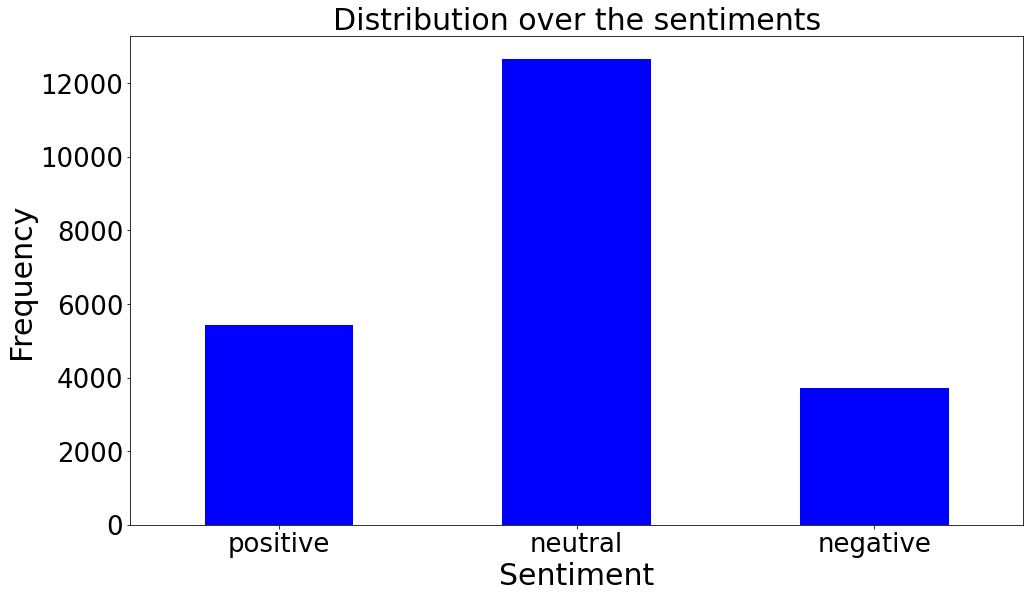

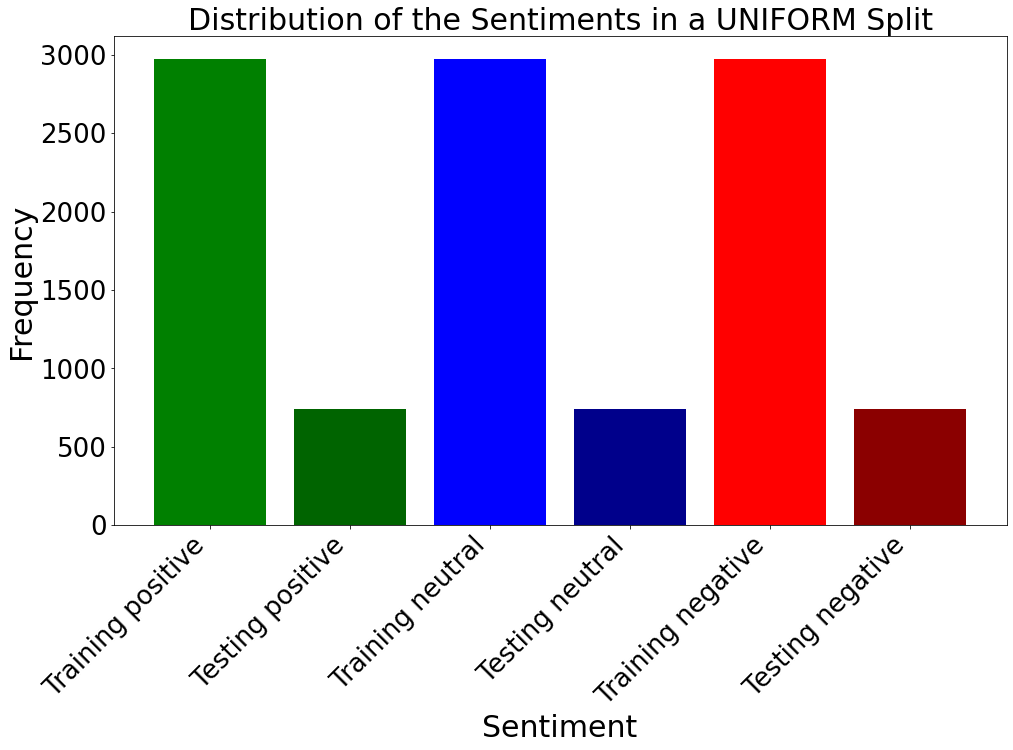

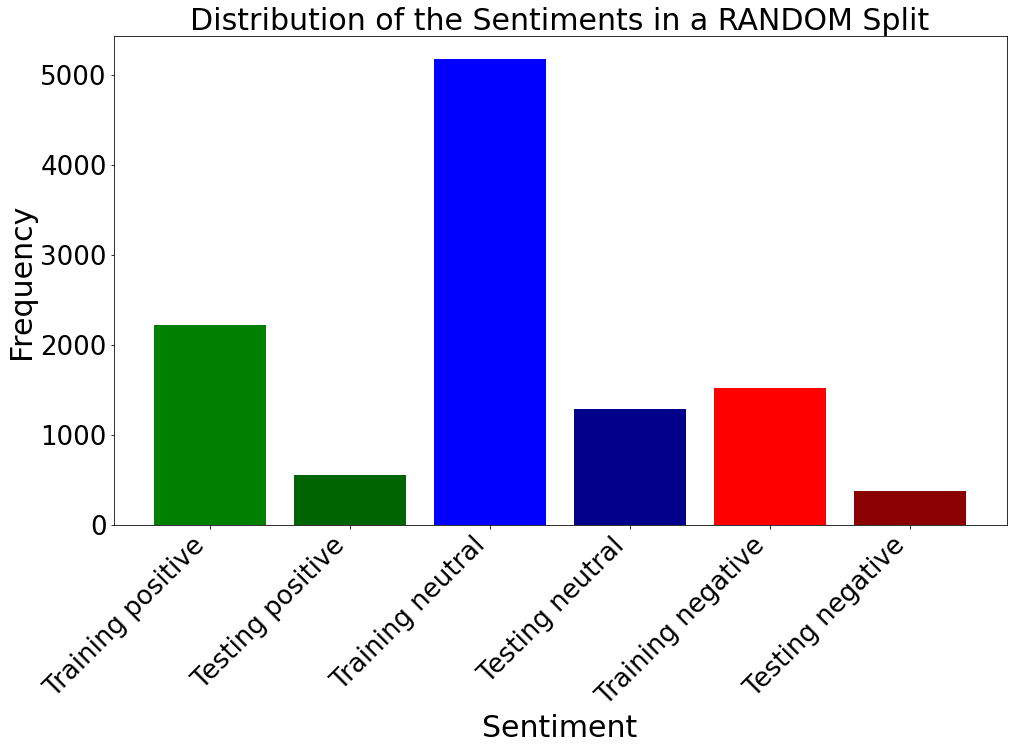

In [86]:
# as a reminder: Distribution of the data between the sentiments
train_df.groupby('sentiment').count().sort_values('sentiment', ascending=False).plot.bar(
    legend=False, figsize=(16, 9), color='blue', rot=0)
plt.xlabel('Sentiment')
plt.ylabel('Frequency')
plt.title('Distribution over the sentiments')
plt.savefig('../report/img/sentiment-distribution', bbox_inches='tight')

uni_df_train, uni_df_test = generate_uniform_sentiments(train_df)
show_save_sentiment_distribution(uni_df_train['sentiment'], uni_df_test['sentiment'], train_df['sentiment'], 'Uniform')

giv_df_train, giv_df_test = generate_given_sentiments(train_df, 
    train_uniform_len=len(uni_df_train), test_uniform_len=len(uni_df_test))
show_save_sentiment_distribution(giv_df_train['sentiment'], giv_df_test['sentiment'], train_df['sentiment'], 'Random')

In [87]:
# implement my own version of cross validation
def generate_cv_splits(df: pd.DataFrame, feature_types: list[str] = CHOSEN_FEATURES, 
        max_features: int = MAX_FEATURES, cv = 10):

    splits = []
    new_df = df.copy()

    # df_train, df_test = train_test_split(df, test_size=1/cv, shuffle=False)
    for i in range(cv):
        df_train, df_test, _, _ = train_test_split(new_df, new_df['sentiment'], test_size=1/cv, shuffle=False)

        # the features to extract
        X_train, X_test = extract_features(df_train, df_test, feature_types, max_features)
        y_train = df_train['sentiment']
        y_test = df_test['sentiment']

        splits.append((X_train, X_test, y_train, y_test))

        # # generate the score
        # model.fit(X_train, y_train)
        # scores.append(model.score(X_test, y_test))

        # # recombine
        new_df = pd.concat([df_test, df_train])
    
    return splits

def generate_uniform_given_splits(df: pd.DataFrame, feature_types: list[str] = CHOSEN_FEATURES, 
        max_features: int = MAX_FEATURES, cv = 10):
    uni_df_train, uni_df_test = generate_uniform_sentiments(df)
    uni_df = pd.concat([uni_df_train, uni_df_test])
    uni_splits = generate_cv_splits(uni_df, feature_types, max_features)

    giv_df_train, giv_df_test = generate_given_sentiments(df, 
        train_uniform_len=len(uni_df_train), test_uniform_len=len(uni_df_test))
    giv_df = pd.concat([giv_df_train, giv_df_test])
    giv_splits = generate_cv_splits(giv_df, feature_types, max_features)

    return (uni_splits, giv_splits)


#### Evaluation Functions

In [88]:
# implement my own version of cross validation
def evaluate_cross_val(model, cv_splits: list):

    scores = {
        'train-scores': [],
        'test-scores': [],
    }

    for s in cv_splits:

        X_train, X_test, y_train, y_test = s

        # generate the score
        model.fit(X_train, y_train)
        scores['test-scores'].append(model.score(X_test, y_test))
        scores['train-scores'].append(model.score(X_train, y_train))
    
    return scores

# generate the evaluation metrics and confusion matrix on a model on given data
def evaluate_metrics(model, _X_train, _X_test, _y_train, _y_test, 
        split_type:str = '', model_name:str = '', max_features = MAX_FEATURES, display:bool = False):
    
    # fit the data and predict
    model.fit(_X_train, _y_train)
    _y_pred = model.predict(_X_test)

    # append a dictionary of the evaluation summaries
    output = {
        'data': (_X_train, _X_test, _y_train, _y_test, _y_pred),
        'evaluation-string': classification_report(_y_test, _y_pred, zero_division=0),
        'evaluation': classification_report(_y_test, _y_pred, output_dict=True, zero_division=0),
        'confusion-matrix': confusion_matrix(_y_test, _y_pred)
    }

    # display the stuff if needed
    if display:
        print(output['evaluation-string'])
        plt.figure(figsize=(32, 18))
        ConfusionMatrixDisplay.from_predictions(_y_test, _y_pred, xticks_rotation=45,
            labels = sorted(set(_y_test), reverse=True))
        plt.title(f'{model_name}\nConfusion Matrix on {split_type.upper()} Data \n({max_features} Max Features)')
        model_name = re.sub(r'\W+', '', model_name)
        split_type = re.sub(r'\W+', '', split_type)
        plt.savefig(f'../report/img/cf/{model_name}-{split_type}-confusion-matrix-{max_features}mf.png', 
            bbox_inches='tight')

    return output

SPLIT_ALL = 'All'
SPLIT_GIVEN_ON_UNIFORM = 'Given Training\n and Uniform Testing'
SPLIT_UNIFORM_ON_GIVEN = 'Uniform Training\n and Given Testing'
# evaluate a model on the different data splits, then on overall data
def evaluate(model, df, model_name:str = '', feature_types: list[str] = CHOSEN_FEATURES, 
        max_features: int = MAX_FEATURES, display:bool=False):
    
    output = {}

    # get the uniform split
    if display: print(f'=== Over {SPLIT_UNIFORM} Data ===')
    # uni_X_train, uni_X_test, uni_y_train, uni_y_test = generate_uniform_sentiments(_X, _y)
    uni_df_train, uni_df_test = generate_uniform_sentiments(df)
    uni_X_train, uni_X_test = extract_features(uni_df_train, uni_df_test, feature_types, max_features)
    uni_y_train = uni_df_train['sentiment']
    uni_y_test = uni_df_test['sentiment']
    output[SPLIT_UNIFORM] = evaluate_metrics(model, uni_X_train, uni_X_test, uni_y_train, uni_y_test, 
        split_type=SPLIT_UNIFORM, model_name=model_name, display=display)

    # get the random split
    if display: print(f'=== Over {SPLIT_GIVEN} Data ===')
    giv_df_train, giv_df_test = generate_given_sentiments(df, 
        train_uniform_len=len(uni_df_train), test_uniform_len=len(uni_df_test))
    giv_X_train, giv_X_test = extract_features(giv_df_train, giv_df_test, feature_types, max_features)
    giv_y_train = giv_df_train['sentiment']
    giv_y_test = giv_df_test['sentiment']
    output[SPLIT_GIVEN] = evaluate_metrics(model, giv_X_train, giv_X_test, giv_y_train, giv_y_test, 
        split_type=SPLIT_GIVEN, model_name=model_name, display=display)

    
    gou_X_train, gou_X_test = extract_features(giv_df_train, uni_df_test, feature_types, max_features)
    gou_y_train = giv_df_train['sentiment']
    gou_y_test = uni_df_test['sentiment']
    
    # train on random and test on uniform
    if display: print(f'=== Over {SPLIT_GIVEN_ON_UNIFORM} Data ===')
    output[SPLIT_GIVEN_ON_UNIFORM] = evaluate_metrics(model, gou_X_train, gou_X_test, gou_y_train, gou_y_test, 
        split_type=SPLIT_GIVEN_ON_UNIFORM, model_name=model_name, display=display)

    uog_X_train, uog_X_test = extract_features(uni_df_train, giv_df_test, feature_types, max_features)
    uog_y_train = uni_df_train['sentiment']
    uog_y_test = giv_df_test['sentiment']

    # train on uniform and test on random
    if display: print(f'=== Over {SPLIT_UNIFORM_ON_GIVEN} Data ===')
    output[SPLIT_UNIFORM_ON_GIVEN] = evaluate_metrics(model, uog_X_train, uog_X_test, uog_y_train, uog_y_test, 
        split_type=SPLIT_UNIFORM_ON_GIVEN, model_name=model_name, display=display)

    # # now test evaluate over the whole set
    # all_X_train, all_X_test = extract_features(df, df, feature_types, max_features)
    # y = df['sentiment']
    # if display: print(f'=== Over {SPLIT_ALL} Data ===')
    # output[SPLIT_ALL] = evaluate_metrics(model, all_X_train, all_X_test, y, y,
    #     split_type=SPLIT_ALL, model_name=model_name, display=display)
    
    return output

#### Start the model dictionairy

In [89]:
TYPE_CLASSIFIER = 'classifier'
TYPE_SCORES = 'cv-scores'
TYPE_EVALUATION = 'evaluation'
# will store the cv scores of all the models below, which can then be used to find the best models.
mf_models = {}
mfs = [10, 100, 1000, 5000, 10000]

### Baseline Model (0-R)

In [90]:
if False: # baseline results don't change so skip this once it's been done once
    model_name = 'Most Frequent Class (0-R)'
    print(model_name)
    model_baseline = {}
    # create the model
    model_baseline[TYPE_CLASSIFIER] = DummyClassifier(strategy="most_frequent")
    splits = generate_cv_splits(train_df, max_features=1)
    model_baseline[TYPE_SCORES] = evaluate_cross_val(model_baseline[TYPE_CLASSIFIER], splits)
    pprint(model_baseline)

    # Evaluate the model
    model_baseline[TYPE_EVALUATION] = evaluate(model_baseline[TYPE_CLASSIFIER], train_df, model_name, display=True)

### Finding the Highest Accuracy Parameter/Classifier Configurations.

#### Define possible parameter combinations

In [104]:
# warning takes up too much space so theyre suppressed, but noted
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=skl.exceptions.ConvergenceWarning)

# Generate the parameters for the pipeline
parameters = [
    {  # Multinomial/Bernoulli Naive Bayes
        TYPE_CLASSIFIER: [MultinomialNB(), BernoulliNB()],
        'alpha': [0, 1, 5, 10],
        'fit_prior': [True, False],
    },
    {  # Logistic Regressions
        TYPE_CLASSIFIER: [LogisticRegression(n_jobs=-1, max_iter=500, solver='saga')],
    },
    {  # Decision Trees
        TYPE_CLASSIFIER: [DecisionTreeClassifier()],
        'max_depth': [1, 100, 500],
    },
    {  # K Nearest Neighbours
        TYPE_CLASSIFIER: [KNeighborsClassifier(n_jobs=-1)],
        'n_neighbors': [1, 10, 100, 500],
        'weights': ['uniform', 'distance'],
    },
    {  # Linear Support Vector Classifiers
        TYPE_CLASSIFIER: [LinearSVC()],
        'C': [0.1, 1, 3],
    },
]

model_parameters = ParameterGrid(parameters)

#### Choose the top 3 classifers by average score
Specifically, use `average - std` as the sorting key. This is the approximate lower bound for 80% of the highest accuracies

In [105]:
def upper_interval(model):
    scores = model[TYPE_SCORES]['test-scores']
    model[TYPE_SCORES]['test-average'] = np.ma.average(scores)
    model[TYPE_SCORES]['test-std'] = np.ma.std(scores)
    n = len(scores)
    t_value = t.ppf(0.95, df=n-1)
    key = model[TYPE_SCORES]['test-average']
    key -= (t_value *  model[TYPE_SCORES]['test-std']) / n**0.5
    model[TYPE_SCORES]['key'] = key
    return key

#### Testing different `max_features` values

In [106]:
for mf in mfs:
    mf_models[mf] = []

    # this is not spam I just need these for my eyes to identify sections within outputs
    print('#'*72)
    print('#'*72)
    print('#'*72)
    print(f'#=== {mf} Max Features ===#')
    print('#'*72)
    print('#'*26 + ' GENERATING SPLITS ' + '#'*27)
    # uni_splits, giv_splits = generate_uniform_given_splits(train_df, max_features=mf)
    data_splits = generate_cv_splits(train_df, max_features=mf)
    print('#'*72)
    # test the max_features value
    for paramSet in model_parameters:
        params = dict([(key, values) for (key, values) in paramSet.items() if key != TYPE_CLASSIFIER])
        paramSet[TYPE_CLASSIFIER].set_params(**params)
        start_time = time()
        print(f'\n#--- Cross-Validating {paramSet} ---#')
        paramSet[TYPE_SCORES] = evaluate_cross_val(paramSet[TYPE_CLASSIFIER], data_splits)
        pprint(paramSet[TYPE_SCORES])
        delta_time = time() - start_time
        print(f'# Evaluation Elapsed Time: {delta_time:.2f}s')
        print(',')
        mf_models[mf].append({
            'params': params,
            TYPE_SCORES: paramSet[TYPE_SCORES],
            TYPE_CLASSIFIER: clone(paramSet[TYPE_CLASSIFIER])
        })

    # find the top three
    print('#'*72) # this is not spam I just need these for my eyes to identify sections within outputs
    print(f'#--- Top 3 ---#')
    print('#'*72)
    mf_models[mf] = sorted(mf_models[mf], reverse=True, key=upper_interval)
    pprint(mf_models[mf][:3])

########################################################################
########################################################################
########################################################################
#=== 10 Max Features ===#
########################################################################
########################## GENERATING SPLITS ###########################
########################################################################

#--- Cross-Validating {'alpha': 0, 'classifier': MultinomialNB(alpha=0), 'fit_prior': True} ---#
{'test-scores': [0.547455295735901,
                 0.5662540119211371,
                 0.5878037597432371,
                 0.5644199908298946,
                 0.5662540119211371,
                 0.5616689591930307,
                 0.5635029802842733,
                 0.5593764328289775,
                 0.5529573590096286,
                 0.5630444750114626],
 'train-scores': [0.570205392181846,
                  0.55833036032

#### Learning Curve for `max_features` values

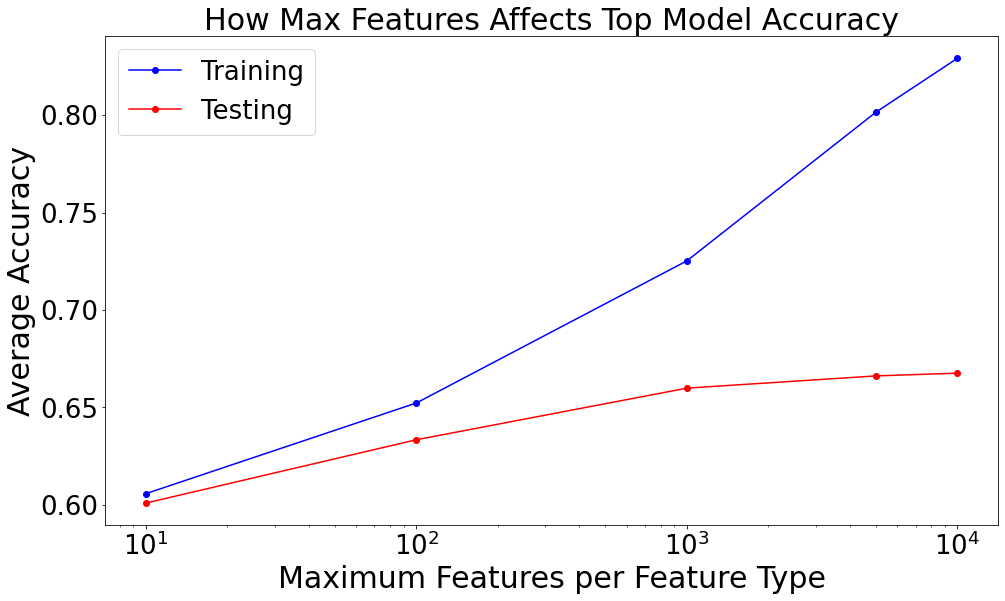

In [111]:
train_accs = []
test_accs = []

for mf in mfs:
    m = mf_models[mf][0]
    train_accs.append(np.ma.average(m[TYPE_SCORES]['train-scores']))
    test_accs.append(np.ma.average(m[TYPE_SCORES]['test-scores']))

plt.figure(figsize=(16,9))
plt.plot(mfs, train_accs, 'bo-')
plt.plot(mfs, test_accs, 'ro-')
plt.title('How Max Features Affects Top Model Accuracy')
plt.xlabel('Maximum Features per Feature Type')
plt.ylabel('Average Accuracy')
plt.legend(['Training', 'Testing'])
plt.xscale('log')
plt.savefig('../report/img/how-mf-varies-accuracies.png', bbox_inches='tight')

# Choose the final max feature values
FINAL_MAX_FEATURES = 10000

In [116]:
def upper_interval(model):
    scores = model[TYPE_SCORES]['test-scores']
    model[TYPE_SCORES]['test-average'] = np.ma.average(scores)
    model[TYPE_SCORES]['test-std'] = np.ma.std(scores)
    n = len(scores)
    t_value = t.ppf(0.95, df=n-1)
    key = model[TYPE_SCORES]['test-average']
    key -= (t_value *  model[TYPE_SCORES]['test-std']) / n**0.5
    model[TYPE_SCORES]['key'] = key
    return key

1.8331129326536333


#### Now that I know the top 3 classifiers
Generate the evaluation metrics for each

In [113]:
def generate_predictions(model, X_train, X_test, y_train, split_type, feature_types = CHOSEN_FEATURES, max_features = MAX_FEATURES):
    m = clone(model[TYPE_CLASSIFIER])
    m.fit(X_train, y_train)

    test_predictions = m.predict(X_test)
    test_out = pd.DataFrame({'id': test_df['id'], 'sentiment': test_predictions})
    test_out.to_csv(f'../out/pred-{model[TYPE_CLASSIFIER]}-on-{split_type}-{max_features}-mf.csv', index = False)

    # out of personal curiosity, also try a bagging classifier
    # m = clone(model[TYPE_CLASSIFIER])
    # m = BaggingClassifier(base_estimator=m)

    # m.fit(X_train, y_train)
    # test_predictions = m.predict(X_test)
    # test_out = pd.DataFrame({'id': test_df['id'], 'sentiment': test_predictions})
    # test_out.to_csv(f'../out/pred-bagging-{model[TYPE_CLASSIFIER]}-on-{split_type}.csv', index = False)

LogisticRegression(max_iter=500, n_jobs=-1, solver='saga')
=== Over Uniform Data ===
              precision    recall  f1-score   support

    negative       0.68      0.69      0.69       743
     neutral       0.53      0.54      0.54       743
    positive       0.68      0.66      0.67       743

    accuracy                           0.63      2229
   macro avg       0.63      0.63      0.63      2229
weighted avg       0.63      0.63      0.63      2229

=== Over Given Data ===
              precision    recall  f1-score   support

    negative       0.56      0.29      0.38       378
     neutral       0.67      0.84      0.74      1290
    positive       0.64      0.49      0.55       561

    accuracy                           0.66      2229
   macro avg       0.62      0.54      0.56      2229
weighted avg       0.64      0.66      0.63      2229

=== Over Given Training
 and Uniform Testing Data ===
              precision    recall  f1-score   support

    negative       0

<Figure size 2304x1296 with 0 Axes>

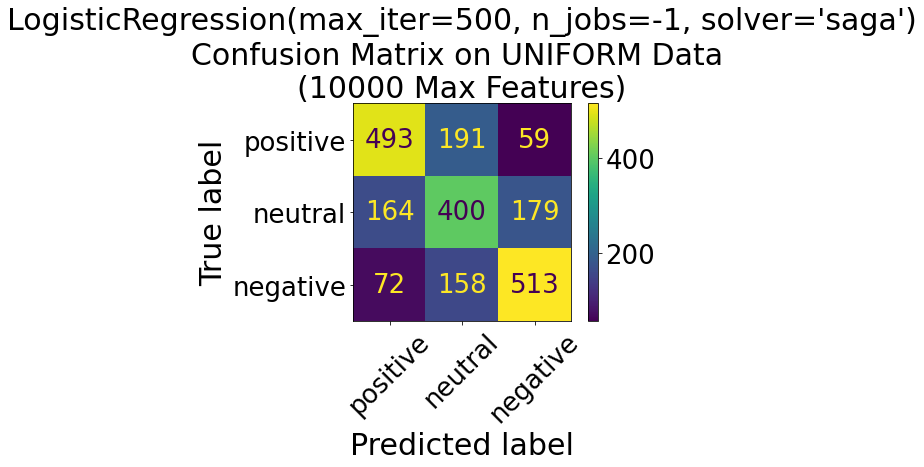

<Figure size 2304x1296 with 0 Axes>

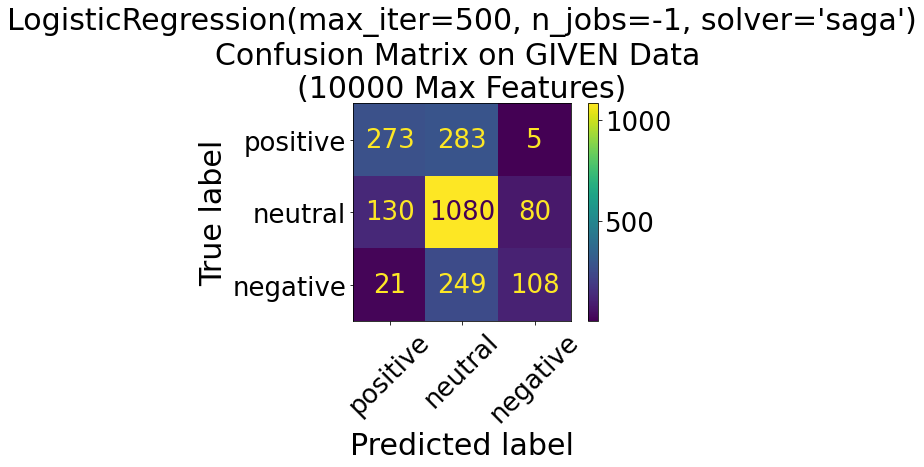

<Figure size 2304x1296 with 0 Axes>

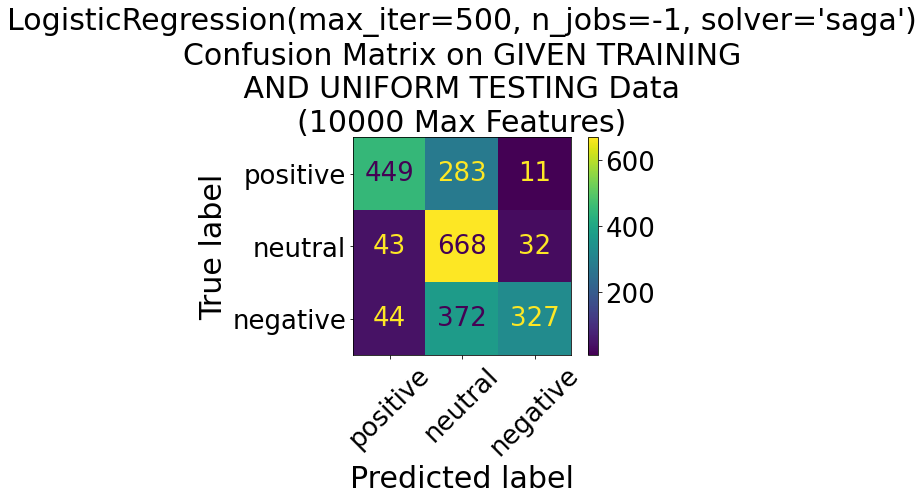

<Figure size 2304x1296 with 0 Axes>

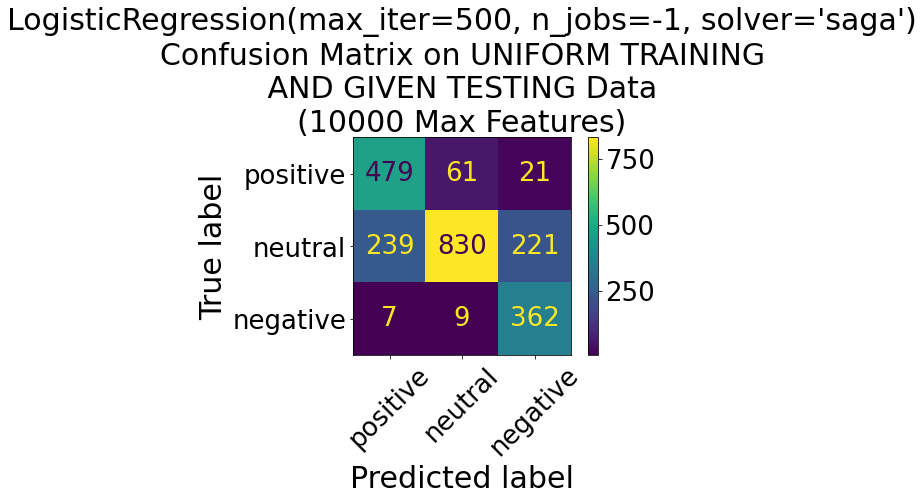

<Figure size 2304x1296 with 0 Axes>

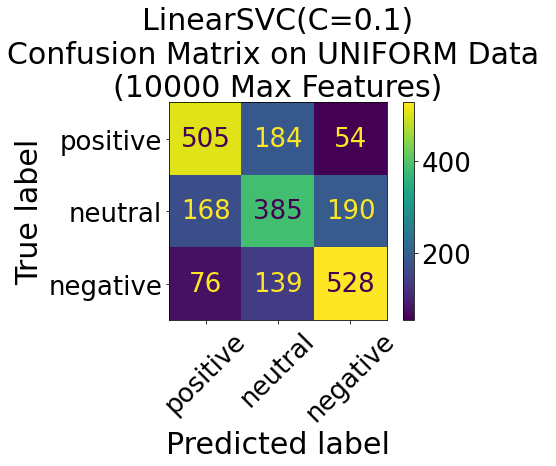

<Figure size 2304x1296 with 0 Axes>

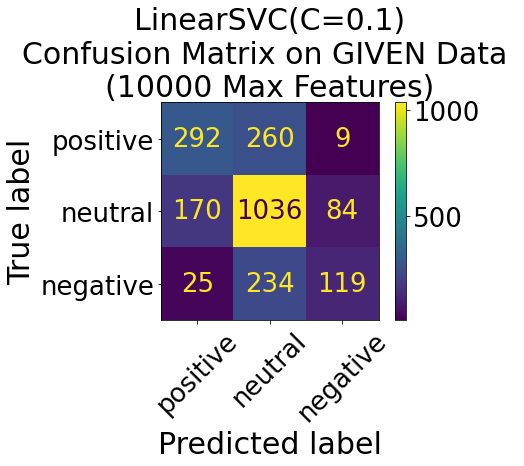

<Figure size 2304x1296 with 0 Axes>

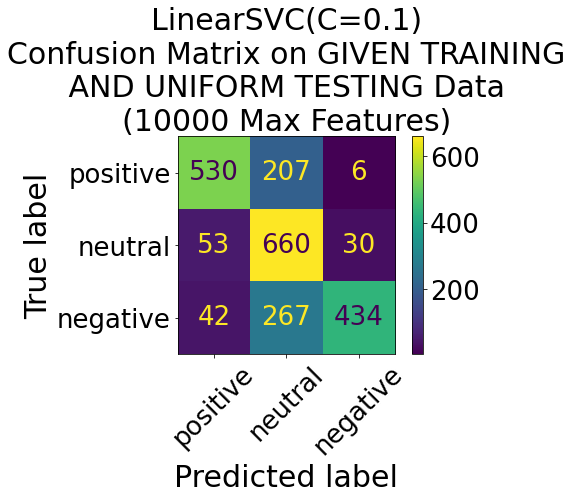

<Figure size 2304x1296 with 0 Axes>

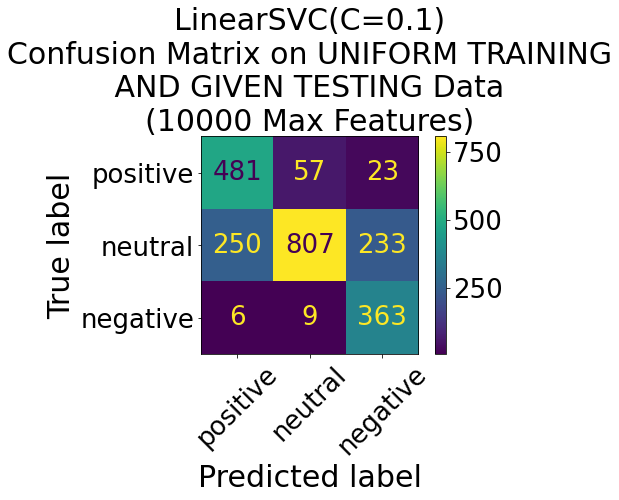

<Figure size 2304x1296 with 0 Axes>

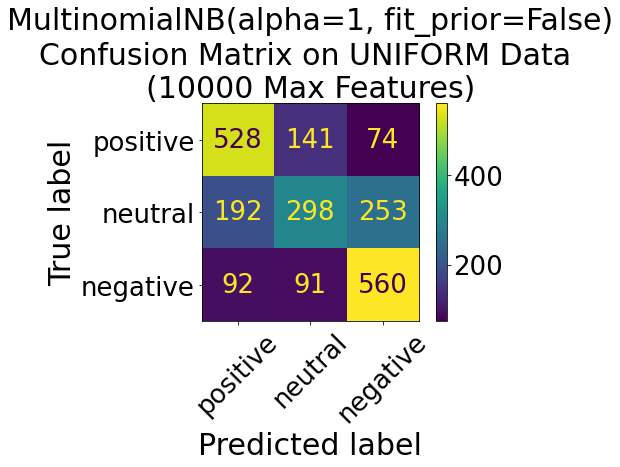

<Figure size 2304x1296 with 0 Axes>

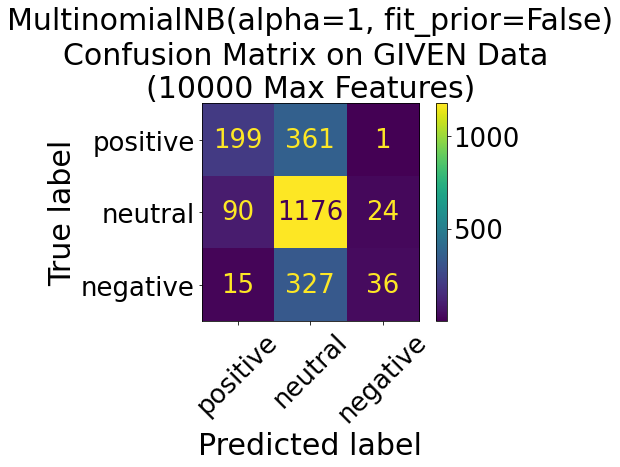

<Figure size 2304x1296 with 0 Axes>

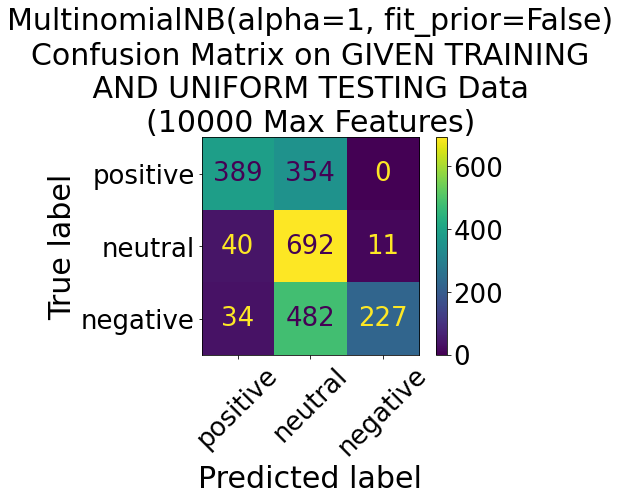

<Figure size 2304x1296 with 0 Axes>

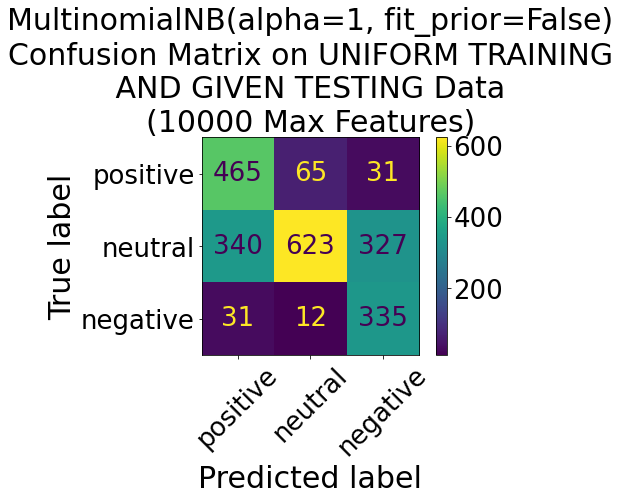

In [117]:
warnings.filterwarnings("ignore", category=RuntimeWarning)

giv_X_train, giv_X_test = extract_features(train_df, test_df)
giv_y = train_df['sentiment']
uni_dfs = generate_uniform_sentiments(train_df)
uni_df_train = pd.concat(uni_dfs)
uni_X_train, uni_X_test = extract_features(uni_df_train, test_df)
uni_y = uni_df_train['sentiment']

# top 3 evaluation metrics
for m in mf_models[FINAL_MAX_FEATURES][:3]:

    print(m[TYPE_CLASSIFIER])
    # Evaluate the model
    m[TYPE_EVALUATION] = evaluate(m[TYPE_CLASSIFIER], train_df, str(m[TYPE_CLASSIFIER]), 
        max_features=FINAL_MAX_FEATURES, display=True)

    # predictions on whole dataset
    generate_predictions(m, giv_X_train, giv_X_test, giv_y, 
        max_features=FINAL_MAX_FEATURES, split_type=SPLIT_GIVEN)
    # predictions on uniform set
    generate_predictions(m, uni_X_train, uni_X_test, uni_y, 
        max_features=FINAL_MAX_FEATURES, split_type=SPLIT_UNIFORM)